<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [35]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [55]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])];
t_save = [solver.sim_time];
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing
u_save=np.array(u_save) # convert u_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s


2025-11-13 15:10:44,011 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s


INFO:__main__:Starting main loop


2025-11-13 15:10:44,019 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-13 15:10:44,184 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2025-11-13 15:10:44,186 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2025-11-13 15:10:44,191 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.06048 sec


2025-11-13 15:10:44,193 solvers 0/1 INFO :: Setup time (init - iter 0): 0.06048 sec


INFO:solvers:Warmup time (iter 0-10): 0.04559 sec


2025-11-13 15:10:44,195 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.04559 sec


INFO:solvers:Run time (iter 10-end): 0.1195 sec


2025-11-13 15:10:44,198 solvers 0/1 INFO :: Run time (iter 10-end): 0.1195 sec


INFO:solvers:CPU time (iter 10-end): 3.318e-05 cpu-hr


2025-11-13 15:10:44,200 solvers 0/1 INFO :: CPU time (iter 10-end): 3.318e-05 cpu-hr


INFO:solvers:Speed: 1.54e+06 mode-stages/cpu-sec


2025-11-13 15:10:44,201 solvers 0/1 INFO :: Speed: 1.54e+06 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-13 15:10:46,247 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp2lqpsy8n/temp.m4v


2025-11-13 15:10:46,250 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp2lqpsy8n/temp.m4v


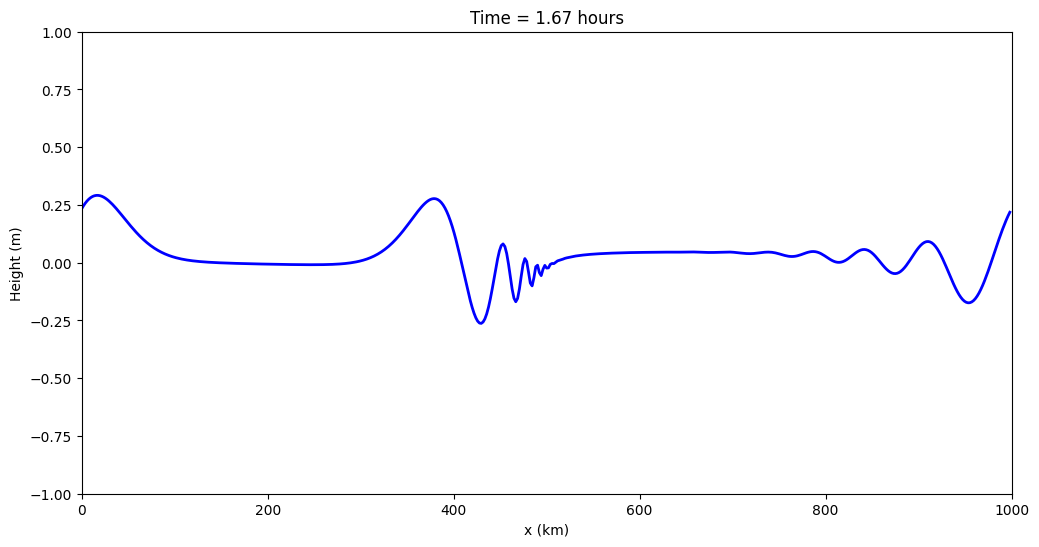

In [56]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

ADD EXPRESSION FOR EXPECTED WAVE SPEED AND EXPLANATION HERE

In [57]:
wave_position = []
for t in h_save:
  x_pos = np.argmax(t)
  wave_position.append(x_pos)

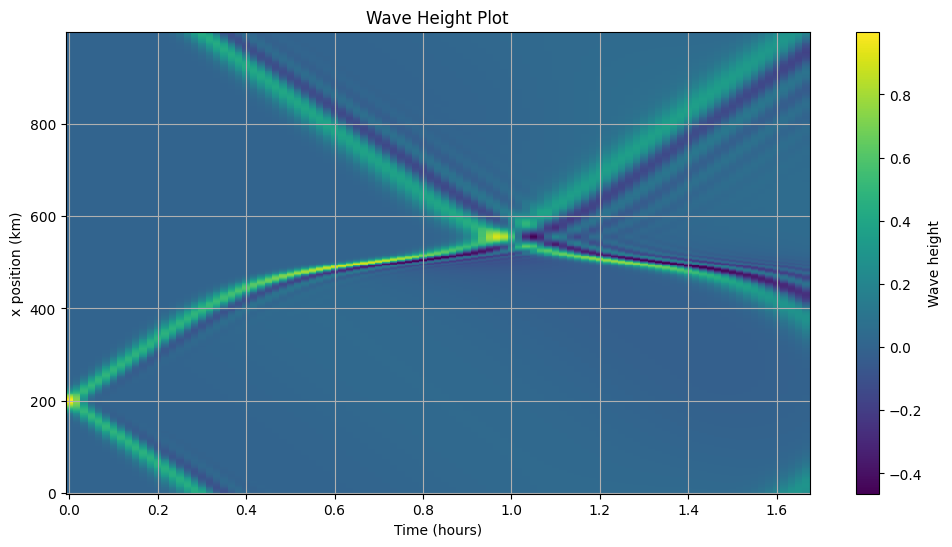

In [62]:
# used gemini to help generate plot
plt.figure(figsize=(12, 6))
plt.pcolormesh(np.array(t_save) / hour, x / kilometer, h_save.T, shading='auto', cmap='viridis')
plt.colorbar(label='Wave height')
plt.xlabel('Time (hours)')
plt.ylabel('x position (km)')
plt.title('Wave Height Plot')
plt.grid(True)
plt.show()

COMMENT ON RESULTS

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + \partial_x(u*H) + \partial_y(v*H)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will initilize the Tsunami with the following equation
$$ h=e^{-x^2/w_1^2} $$
$$ u=(g/c)*h $$

where $c=\sqrt{gH_0}$ and $H_0$ is the constant reference depth. The relationship between $u$ and $h$ follows from linearized shallow water equations and corresponds to a wave propagating in the $+x$ direction with a speed $c$.

We will solve the equations in a square domain with periodic boundary conditions and a Gaussian seamount in the middle of the domain with height

$$ H=H_{min}e^{-(x^2+y^2)/w_2^2} $$

The Tsunami should propagate with speed $c$ over the deep ocean where the depth is constant, but the wave will be modified as it passes over the seamount.

### 2.1  Dedalus script to solve the 2D shallow water equations

In [71]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 50 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 16s, Remaining: 0s, Rate: 6.1e-02/s


2025-11-13 15:25:37,481 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 16s, Remaining: 0s, Rate: 6.1e-02/s


INFO:__main__:Starting main loop


2025-11-13 15:25:37,487 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-13 15:25:45,568 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-13 15:25:45,569 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-13 15:25:45,573 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 16.28 sec


2025-11-13 15:25:45,576 solvers 0/1 INFO :: Setup time (init - iter 0): 16.28 sec


INFO:solvers:Warmup time (iter 0-10): 3.948 sec


2025-11-13 15:25:45,578 solvers 0/1 INFO :: Warmup time (iter 0-10): 3.948 sec


INFO:solvers:Run time (iter 10-end): 4.132 sec


2025-11-13 15:25:45,579 solvers 0/1 INFO :: Run time (iter 10-end): 4.132 sec


INFO:solvers:CPU time (iter 10-end): 0.001148 cpu-hr


2025-11-13 15:25:45,581 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001148 cpu-hr


INFO:solvers:Speed: 2.882e+05 mode-stages/cpu-sec


2025-11-13 15:25:45,582 solvers 0/1 INFO :: Speed: 2.882e+05 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

In [69]:
from dedalus.extras import plot_tools

def animate_h(h_save, t_save):
  # create a figure and axes
  fig = plt.figure(figsize=(6,6))

  # Create arrays with the x and y coordinates for plotting using pcolor
  (X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

  # Define an animation function
  def drawframe(n):
      plt.clf # clear the figure before plotting the next frame
      height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
      # Specify the axis limits and labels
      plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
      plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
      plt.xlabel('x (km)')
      plt.ylabel('y (m)')
      plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
      return (height,)

  from matplotlib import animation
  # blit=True re-draws only the parts that have changed.
  anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

  from IPython.display import HTML
  HTML(anim.to_html5_video())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-13 15:23:55,002 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpuhz9n_6s/temp.m4v


2025-11-13 15:23:55,005 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpuhz9n_6s/temp.m4v


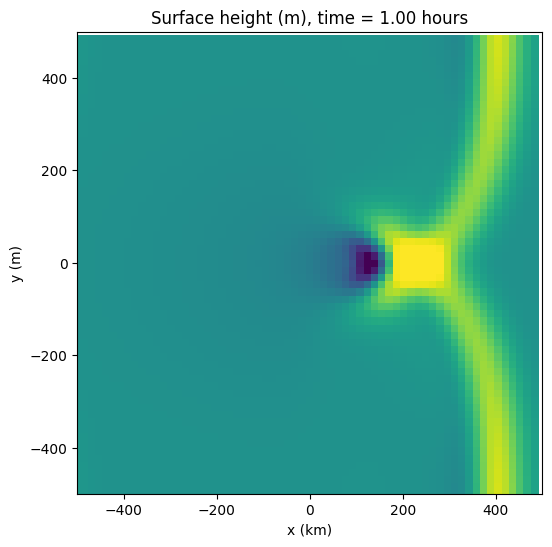

In [70]:
animate_h(h_save, t_save)

### 2.3 Student investigation
<a id='section2pt3'></a>
Qualitatively describe the influence of the seamount and explain this behavior using the shallow water equations. You can assume that the wave amplitude and velocity are small in the shallow water equations.

STUDENT ANSWER HERE (~ 1 PARAGRAPH)

It causes it to lag behind

Try varying some parameters (e.g. the width and height of the wave and/or seamount) and comment on the results. When does the wave no longer obey the linear shallow water equations which are valid for small waves You don't need to do a comprehensive parameter space search, but you should run several simulations with one or two parameters varied.

In [65]:
# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 50 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

def get_h_for_time(Lx = 1000 * kilometer, Ly = 1000 * kilometer, Nx = 64, Ny = 64, g = 9.81, H0 = 4 * kilometer, c = np.sqrt(9.81*4*kilometer), H_min = 1 * kilometer, w1 = 50 * kilometer, w2 = 200 * kilometer, x1 = -300 * kilometer):
  timestep = 60 * second # Specify the timestep
  stop_sim_time = 60 * minute # Specify the stopping time

  timestepper = dedalus.RK222
  max_timestep = 0.125

  # Bases
  coords = dedalus.CartesianCoordinates('x', 'y')
  dist = dedalus.Distributor(coords, dtype=np.float64)
  xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
  ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

  x, y = dist.local_grids(xbasis, ybasis)

  # Fields
  u = dist.Field(name='u', bases=(xbasis, ybasis))
  v = dist.Field(name='v', bases=(xbasis, ybasis))
  h = dist.Field(name='h', bases=(xbasis, ybasis))
  H = dist.Field(name='H', bases=(xbasis, ybasis))

  # Initial conditions
  H.change_scales(1)
  h.change_scales(1) # Set values on regular grid
  u.change_scales(1)
  v.change_scales(1)
  H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
  h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
  u['g'] = (g/c)*h['g']
  v['g'] = 0

  # Operators
  dx = lambda a: dedalus.Differentiate(a, coords['x'])
  dy = lambda a: dedalus.Differentiate(a, coords['y'])

  # Problem
  problem = dedalus.IVP([u, v, h], namespace=locals())
  problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
  problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
  problem.add_equation("dt(h) + (dx(H*u) + dy(H*v)) = - dx(h*u) - dy(h*v)")

  # Solver
  solver = problem.build_solver(dedalus.RK222)
  solver.stop_sim_time = stop_sim_time

  # Analysis
  snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
  snapshots.add_task(h, name='h')
  snapshots.add_task(u, name='u')
  snapshots.add_task(v, name='v')

  h.change_scales(1)
  h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
  # Main loop
  try:
      logger.info('Starting main loop')
      while solver.proceed:
          solver.step(timestep)
          if (solver.iteration-1) % 1 == 0:
              h.change_scales(1)
              h_save.append(np.copy(h['g']))
              t_save.append(solver.sim_time)
  except:
      logger.error('Exception raised, triggering end of main loop.')
      raise
  finally:
      solver.log_stats()

  h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing
  return h_save, t_save

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 16s, Remaining: 0s, Rate: 6.1e-02/s


2025-11-13 15:26:13,671 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 16s, Remaining: 0s, Rate: 6.1e-02/s


INFO:__main__:Starting main loop


2025-11-13 15:26:13,677 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-13 15:26:22,184 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-13 15:26:22,185 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-13 15:26:22,187 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 16.41 sec


2025-11-13 15:26:22,188 solvers 0/1 INFO :: Setup time (init - iter 0): 16.41 sec


INFO:solvers:Warmup time (iter 0-10): 4.428 sec


2025-11-13 15:26:22,190 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.428 sec


INFO:solvers:Run time (iter 10-end): 4.078 sec


2025-11-13 15:26:22,191 solvers 0/1 INFO :: Run time (iter 10-end): 4.078 sec


INFO:solvers:CPU time (iter 10-end): 0.001133 cpu-hr


2025-11-13 15:26:22,192 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001133 cpu-hr


INFO:solvers:Speed: 2.92e+05 mode-stages/cpu-sec


2025-11-13 15:26:22,193 solvers 0/1 INFO :: Speed: 2.92e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-13 15:26:22,555 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpvn46r65f/temp.m4v


2025-11-13 15:26:22,557 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpvn46r65f/temp.m4v


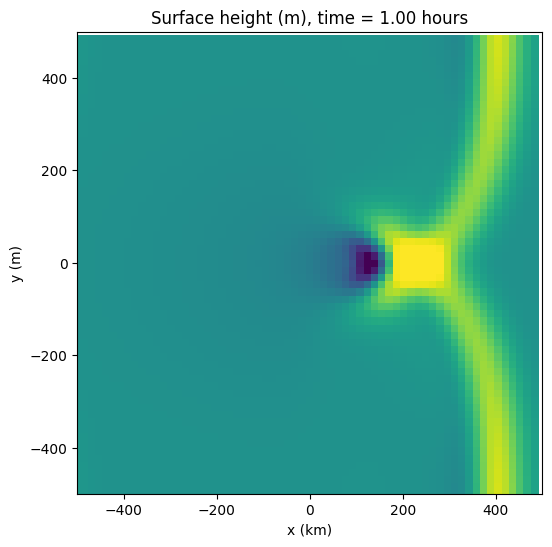

In [72]:
h_save, t_save = get_h_for_time()
animate_h(h_save, t_save)


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 16s, Remaining: 0s, Rate: 6.2e-02/s


2025-11-13 15:28:54,018 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 16s, Remaining: 0s, Rate: 6.2e-02/s


INFO:__main__:Starting main loop


2025-11-13 15:28:54,024 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-13 15:29:02,036 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-13 15:29:02,038 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-13 15:29:02,042 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 16.18 sec


2025-11-13 15:29:02,043 solvers 0/1 INFO :: Setup time (init - iter 0): 16.18 sec


INFO:solvers:Warmup time (iter 0-10): 4.083 sec


2025-11-13 15:29:02,045 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.083 sec


INFO:solvers:Run time (iter 10-end): 3.929 sec


2025-11-13 15:29:02,047 solvers 0/1 INFO :: Run time (iter 10-end): 3.929 sec


INFO:solvers:CPU time (iter 10-end): 0.001091 cpu-hr


2025-11-13 15:29:02,048 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001091 cpu-hr


INFO:solvers:Speed: 3.031e+05 mode-stages/cpu-sec


2025-11-13 15:29:02,049 solvers 0/1 INFO :: Speed: 3.031e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-13 15:29:02,102 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpc1cp4e18/temp.m4v


2025-11-13 15:29:02,104 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpc1cp4e18/temp.m4v


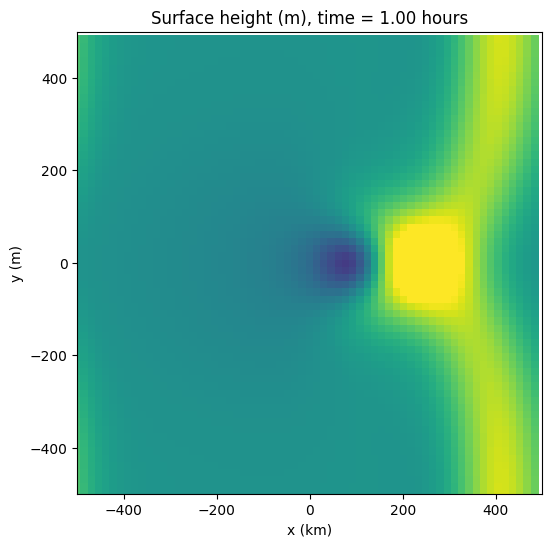

In [73]:
h_save, t_save = get_h_for_time(w1 = 100 * kilometer)
animate_h(h_save, t_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 16s, Remaining: 0s, Rate: 6.1e-02/s


2025-11-13 15:30:44,326 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 16s, Remaining: 0s, Rate: 6.1e-02/s


INFO:__main__:Starting main loop


2025-11-13 15:30:44,331 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-13 15:30:52,260 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-13 15:30:52,262 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-13 15:30:52,266 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 16.35 sec


2025-11-13 15:30:52,267 solvers 0/1 INFO :: Setup time (init - iter 0): 16.35 sec


INFO:solvers:Warmup time (iter 0-10): 3.814 sec


2025-11-13 15:30:52,268 solvers 0/1 INFO :: Warmup time (iter 0-10): 3.814 sec


INFO:solvers:Run time (iter 10-end): 4.116 sec


2025-11-13 15:30:52,269 solvers 0/1 INFO :: Run time (iter 10-end): 4.116 sec


INFO:solvers:CPU time (iter 10-end): 0.001143 cpu-hr


2025-11-13 15:30:52,271 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001143 cpu-hr


INFO:solvers:Speed: 2.893e+05 mode-stages/cpu-sec


2025-11-13 15:30:52,272 solvers 0/1 INFO :: Speed: 2.893e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-13 15:30:52,622 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmphis13akj/temp.m4v


2025-11-13 15:30:52,624 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmphis13akj/temp.m4v


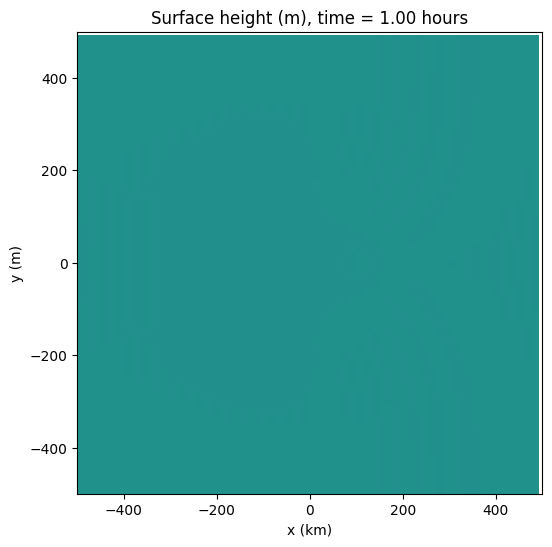

In [74]:
h_save, t_save = get_h_for_time(w1 = 1 * kilometer)
animate_h(h_save, t_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 24s, Remaining: 0s, Rate: 4.1e-02/s


2025-11-13 15:32:41,824 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 24s, Remaining: 0s, Rate: 4.1e-02/s


INFO:__main__:Starting main loop


2025-11-13 15:32:41,830 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-13 15:32:50,098 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-13 15:32:50,099 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-13 15:32:50,102 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 24.22 sec


2025-11-13 15:32:50,106 solvers 0/1 INFO :: Setup time (init - iter 0): 24.22 sec


INFO:solvers:Warmup time (iter 0-10): 4.404 sec


2025-11-13 15:32:50,109 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.404 sec


INFO:solvers:Run time (iter 10-end): 3.863 sec


2025-11-13 15:32:50,114 solvers 0/1 INFO :: Run time (iter 10-end): 3.863 sec


INFO:solvers:CPU time (iter 10-end): 0.001073 cpu-hr


2025-11-13 15:32:50,116 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001073 cpu-hr


INFO:solvers:Speed: 3.083e+05 mode-stages/cpu-sec


2025-11-13 15:32:50,118 solvers 0/1 INFO :: Speed: 3.083e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-13 15:32:50,198 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpnywlnf80/temp.m4v


2025-11-13 15:32:50,201 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpnywlnf80/temp.m4v


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

2025-11-13 15:33:17,920 matplotlib.animation 0/1 WARNING :: MovieWriter stderr:
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora -

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '600x600', '-pix_fmt', 'rgba', '-framerate', '25.0', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpnywlnf80/temp.m4v']' returned non-zero exit status 255.

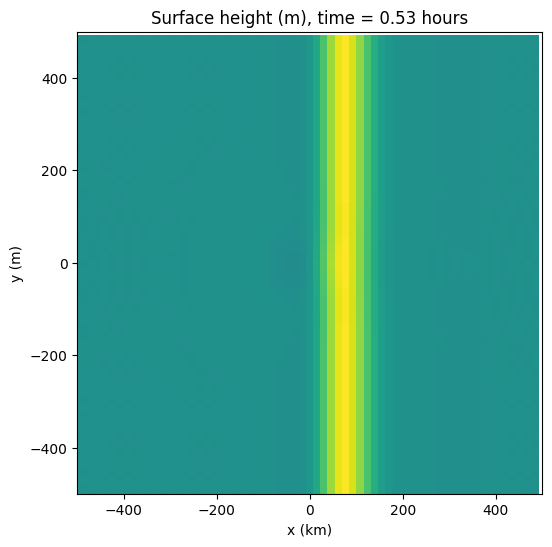

In [75]:
h_save, t_save = get_h_for_time(w2 = 10 * kilometer)
animate_h(h_save, t_save)

In [ ]:
h_save, t_save = get_h_for_time(w2 = 400 * kilometer)
animate_h(h_save, t_save)

In [ ]:
h_save, t_save = get_h_for_time(w2 = 20 * kilometer)
animate_h(h_save, t_save)

STUDENT ANSWER HERE (~ 1 PARAGRAPH)

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way. In this part of the project, we will assume that the bottom of the ocean is flat and that the resting height of the ocean is a constant $H$.  

We will use Dedalus to solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [96]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

# changed for higher resolution
timestep = 120 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 5.6e+01/s


2025-11-13 16:20:25,119 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 5.6e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 6.7e+01/s


2025-11-13 16:20:25,207 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 6.7e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 7.1e+01/s


2025-11-13 16:20:25,300 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 7.0e+01/s


2025-11-13 16:20:25,400 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 7.0e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


2025-11-13 16:20:25,499 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


2025-11-13 16:20:25,598 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 7.1e+01/s


2025-11-13 16:20:25,694 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 7.1e+01/s


2025-11-13 16:20:25,791 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 7.1e+01/s


2025-11-13 16:20:25,885 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.1e+01/s


2025-11-13 16:20:25,984 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.1e+01/s


INFO:__main__:Starting main loop


2025-11-13 16:20:25,992 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.200000e+02, dt=1.200000e+02


2025-11-13 16:20:30,023 __main__ 0/1 INFO :: Iteration=1, Time=1.200000e+02, dt=1.200000e+02


INFO:__main__:Iteration=11, Time=1.320000e+03, dt=1.200000e+02


2025-11-13 16:20:30,958 __main__ 0/1 INFO :: Iteration=11, Time=1.320000e+03, dt=1.200000e+02


INFO:__main__:Iteration=21, Time=2.520000e+03, dt=1.200000e+02


2025-11-13 16:20:31,442 __main__ 0/1 INFO :: Iteration=21, Time=2.520000e+03, dt=1.200000e+02


INFO:__main__:Iteration=31, Time=3.720000e+03, dt=1.200000e+02


2025-11-13 16:20:31,927 __main__ 0/1 INFO :: Iteration=31, Time=3.720000e+03, dt=1.200000e+02


INFO:__main__:Iteration=41, Time=4.920000e+03, dt=1.200000e+02


2025-11-13 16:20:32,416 __main__ 0/1 INFO :: Iteration=41, Time=4.920000e+03, dt=1.200000e+02


INFO:__main__:Iteration=51, Time=6.120000e+03, dt=1.200000e+02


2025-11-13 16:20:32,911 __main__ 0/1 INFO :: Iteration=51, Time=6.120000e+03, dt=1.200000e+02


INFO:__main__:Iteration=61, Time=7.320000e+03, dt=1.200000e+02


2025-11-13 16:20:33,351 __main__ 0/1 INFO :: Iteration=61, Time=7.320000e+03, dt=1.200000e+02


INFO:__main__:Iteration=71, Time=8.520000e+03, dt=1.200000e+02


2025-11-13 16:20:33,804 __main__ 0/1 INFO :: Iteration=71, Time=8.520000e+03, dt=1.200000e+02


INFO:__main__:Iteration=81, Time=9.720000e+03, dt=1.200000e+02


2025-11-13 16:20:34,289 __main__ 0/1 INFO :: Iteration=81, Time=9.720000e+03, dt=1.200000e+02


INFO:__main__:Iteration=91, Time=1.092000e+04, dt=1.200000e+02


2025-11-13 16:20:34,799 __main__ 0/1 INFO :: Iteration=91, Time=1.092000e+04, dt=1.200000e+02


INFO:__main__:Iteration=101, Time=1.212000e+04, dt=1.200000e+02


2025-11-13 16:20:35,250 __main__ 0/1 INFO :: Iteration=101, Time=1.212000e+04, dt=1.200000e+02


INFO:__main__:Iteration=111, Time=1.332000e+04, dt=1.200000e+02


2025-11-13 16:20:35,697 __main__ 0/1 INFO :: Iteration=111, Time=1.332000e+04, dt=1.200000e+02


INFO:__main__:Iteration=121, Time=1.452000e+04, dt=1.200000e+02


2025-11-13 16:20:36,134 __main__ 0/1 INFO :: Iteration=121, Time=1.452000e+04, dt=1.200000e+02


INFO:__main__:Iteration=131, Time=1.572000e+04, dt=1.200000e+02


2025-11-13 16:20:36,588 __main__ 0/1 INFO :: Iteration=131, Time=1.572000e+04, dt=1.200000e+02


INFO:__main__:Iteration=141, Time=1.692000e+04, dt=1.200000e+02


2025-11-13 16:20:37,035 __main__ 0/1 INFO :: Iteration=141, Time=1.692000e+04, dt=1.200000e+02


INFO:__main__:Iteration=151, Time=1.812000e+04, dt=1.200000e+02


2025-11-13 16:20:37,474 __main__ 0/1 INFO :: Iteration=151, Time=1.812000e+04, dt=1.200000e+02


INFO:__main__:Iteration=161, Time=1.932000e+04, dt=1.200000e+02


2025-11-13 16:20:37,917 __main__ 0/1 INFO :: Iteration=161, Time=1.932000e+04, dt=1.200000e+02


INFO:__main__:Iteration=171, Time=2.052000e+04, dt=1.200000e+02


2025-11-13 16:20:38,359 __main__ 0/1 INFO :: Iteration=171, Time=2.052000e+04, dt=1.200000e+02


INFO:__main__:Iteration=181, Time=2.172000e+04, dt=1.200000e+02


2025-11-13 16:20:38,816 __main__ 0/1 INFO :: Iteration=181, Time=2.172000e+04, dt=1.200000e+02


INFO:__main__:Iteration=191, Time=2.292000e+04, dt=1.200000e+02


2025-11-13 16:20:39,257 __main__ 0/1 INFO :: Iteration=191, Time=2.292000e+04, dt=1.200000e+02


INFO:__main__:Iteration=201, Time=2.412000e+04, dt=1.200000e+02


2025-11-13 16:20:39,703 __main__ 0/1 INFO :: Iteration=201, Time=2.412000e+04, dt=1.200000e+02


INFO:__main__:Iteration=211, Time=2.532000e+04, dt=1.200000e+02


2025-11-13 16:20:40,141 __main__ 0/1 INFO :: Iteration=211, Time=2.532000e+04, dt=1.200000e+02


INFO:__main__:Iteration=221, Time=2.652000e+04, dt=1.200000e+02


2025-11-13 16:20:40,587 __main__ 0/1 INFO :: Iteration=221, Time=2.652000e+04, dt=1.200000e+02


INFO:__main__:Iteration=231, Time=2.772000e+04, dt=1.200000e+02


2025-11-13 16:20:41,293 __main__ 0/1 INFO :: Iteration=231, Time=2.772000e+04, dt=1.200000e+02


INFO:__main__:Iteration=241, Time=2.892000e+04, dt=1.200000e+02


2025-11-13 16:20:41,975 __main__ 0/1 INFO :: Iteration=241, Time=2.892000e+04, dt=1.200000e+02


INFO:__main__:Iteration=251, Time=3.012000e+04, dt=1.200000e+02


2025-11-13 16:20:42,646 __main__ 0/1 INFO :: Iteration=251, Time=3.012000e+04, dt=1.200000e+02


INFO:__main__:Iteration=261, Time=3.132000e+04, dt=1.200000e+02


2025-11-13 16:20:43,270 __main__ 0/1 INFO :: Iteration=261, Time=3.132000e+04, dt=1.200000e+02


INFO:__main__:Iteration=271, Time=3.252000e+04, dt=1.200000e+02


2025-11-13 16:20:43,715 __main__ 0/1 INFO :: Iteration=271, Time=3.252000e+04, dt=1.200000e+02


INFO:__main__:Iteration=281, Time=3.372000e+04, dt=1.200000e+02


2025-11-13 16:20:44,187 __main__ 0/1 INFO :: Iteration=281, Time=3.372000e+04, dt=1.200000e+02


INFO:__main__:Iteration=291, Time=3.492000e+04, dt=1.200000e+02


2025-11-13 16:20:44,634 __main__ 0/1 INFO :: Iteration=291, Time=3.492000e+04, dt=1.200000e+02


INFO:__main__:Iteration=301, Time=3.612000e+04, dt=1.200000e+02


2025-11-13 16:20:45,092 __main__ 0/1 INFO :: Iteration=301, Time=3.612000e+04, dt=1.200000e+02


INFO:__main__:Iteration=311, Time=3.732000e+04, dt=1.200000e+02


2025-11-13 16:20:45,526 __main__ 0/1 INFO :: Iteration=311, Time=3.732000e+04, dt=1.200000e+02


INFO:__main__:Iteration=321, Time=3.852000e+04, dt=1.200000e+02


2025-11-13 16:20:45,959 __main__ 0/1 INFO :: Iteration=321, Time=3.852000e+04, dt=1.200000e+02


INFO:__main__:Iteration=331, Time=3.972000e+04, dt=1.200000e+02


2025-11-13 16:20:46,404 __main__ 0/1 INFO :: Iteration=331, Time=3.972000e+04, dt=1.200000e+02


INFO:__main__:Iteration=341, Time=4.092000e+04, dt=1.200000e+02


2025-11-13 16:20:46,838 __main__ 0/1 INFO :: Iteration=341, Time=4.092000e+04, dt=1.200000e+02


INFO:__main__:Iteration=351, Time=4.212000e+04, dt=1.200000e+02


2025-11-13 16:20:47,315 __main__ 0/1 INFO :: Iteration=351, Time=4.212000e+04, dt=1.200000e+02


INFO:__main__:Iteration=361, Time=4.332000e+04, dt=1.200000e+02


2025-11-13 16:20:47,761 __main__ 0/1 INFO :: Iteration=361, Time=4.332000e+04, dt=1.200000e+02


INFO:__main__:Iteration=371, Time=4.452000e+04, dt=1.200000e+02


2025-11-13 16:20:48,216 __main__ 0/1 INFO :: Iteration=371, Time=4.452000e+04, dt=1.200000e+02


INFO:__main__:Iteration=381, Time=4.572000e+04, dt=1.200000e+02


2025-11-13 16:20:48,646 __main__ 0/1 INFO :: Iteration=381, Time=4.572000e+04, dt=1.200000e+02


INFO:__main__:Iteration=391, Time=4.692000e+04, dt=1.200000e+02


2025-11-13 16:20:49,098 __main__ 0/1 INFO :: Iteration=391, Time=4.692000e+04, dt=1.200000e+02


INFO:__main__:Iteration=401, Time=4.812000e+04, dt=1.200000e+02


2025-11-13 16:20:49,549 __main__ 0/1 INFO :: Iteration=401, Time=4.812000e+04, dt=1.200000e+02


INFO:__main__:Iteration=411, Time=4.932000e+04, dt=1.200000e+02


2025-11-13 16:20:49,996 __main__ 0/1 INFO :: Iteration=411, Time=4.932000e+04, dt=1.200000e+02


INFO:__main__:Iteration=421, Time=5.052000e+04, dt=1.200000e+02


2025-11-13 16:20:50,486 __main__ 0/1 INFO :: Iteration=421, Time=5.052000e+04, dt=1.200000e+02


INFO:__main__:Iteration=431, Time=5.172000e+04, dt=1.200000e+02


2025-11-13 16:20:50,915 __main__ 0/1 INFO :: Iteration=431, Time=5.172000e+04, dt=1.200000e+02


INFO:__main__:Iteration=441, Time=5.292000e+04, dt=1.200000e+02


2025-11-13 16:20:51,381 __main__ 0/1 INFO :: Iteration=441, Time=5.292000e+04, dt=1.200000e+02


INFO:__main__:Iteration=451, Time=5.412000e+04, dt=1.200000e+02


2025-11-13 16:20:51,829 __main__ 0/1 INFO :: Iteration=451, Time=5.412000e+04, dt=1.200000e+02


INFO:__main__:Iteration=461, Time=5.532000e+04, dt=1.200000e+02


2025-11-13 16:20:52,297 __main__ 0/1 INFO :: Iteration=461, Time=5.532000e+04, dt=1.200000e+02


INFO:__main__:Iteration=471, Time=5.652000e+04, dt=1.200000e+02


2025-11-13 16:20:52,767 __main__ 0/1 INFO :: Iteration=471, Time=5.652000e+04, dt=1.200000e+02


INFO:__main__:Iteration=481, Time=5.772000e+04, dt=1.200000e+02


2025-11-13 16:20:53,278 __main__ 0/1 INFO :: Iteration=481, Time=5.772000e+04, dt=1.200000e+02


INFO:__main__:Iteration=491, Time=5.892000e+04, dt=1.200000e+02


2025-11-13 16:20:53,954 __main__ 0/1 INFO :: Iteration=491, Time=5.892000e+04, dt=1.200000e+02


INFO:__main__:Iteration=501, Time=6.012000e+04, dt=1.200000e+02


2025-11-13 16:20:54,628 __main__ 0/1 INFO :: Iteration=501, Time=6.012000e+04, dt=1.200000e+02


INFO:__main__:Iteration=511, Time=6.132000e+04, dt=1.200000e+02


2025-11-13 16:20:55,297 __main__ 0/1 INFO :: Iteration=511, Time=6.132000e+04, dt=1.200000e+02


INFO:__main__:Iteration=521, Time=6.252000e+04, dt=1.200000e+02


2025-11-13 16:20:55,878 __main__ 0/1 INFO :: Iteration=521, Time=6.252000e+04, dt=1.200000e+02


INFO:__main__:Iteration=531, Time=6.372000e+04, dt=1.200000e+02


2025-11-13 16:20:56,324 __main__ 0/1 INFO :: Iteration=531, Time=6.372000e+04, dt=1.200000e+02


INFO:__main__:Iteration=541, Time=6.492000e+04, dt=1.200000e+02


2025-11-13 16:20:56,770 __main__ 0/1 INFO :: Iteration=541, Time=6.492000e+04, dt=1.200000e+02


INFO:__main__:Iteration=551, Time=6.612000e+04, dt=1.200000e+02


2025-11-13 16:20:57,207 __main__ 0/1 INFO :: Iteration=551, Time=6.612000e+04, dt=1.200000e+02


INFO:__main__:Iteration=561, Time=6.732000e+04, dt=1.200000e+02


2025-11-13 16:20:57,657 __main__ 0/1 INFO :: Iteration=561, Time=6.732000e+04, dt=1.200000e+02


INFO:__main__:Iteration=571, Time=6.852000e+04, dt=1.200000e+02


2025-11-13 16:20:58,096 __main__ 0/1 INFO :: Iteration=571, Time=6.852000e+04, dt=1.200000e+02


INFO:__main__:Iteration=581, Time=6.972000e+04, dt=1.200000e+02


2025-11-13 16:20:58,532 __main__ 0/1 INFO :: Iteration=581, Time=6.972000e+04, dt=1.200000e+02


INFO:__main__:Iteration=591, Time=7.092000e+04, dt=1.200000e+02


2025-11-13 16:20:58,993 __main__ 0/1 INFO :: Iteration=591, Time=7.092000e+04, dt=1.200000e+02


INFO:__main__:Iteration=601, Time=7.212000e+04, dt=1.200000e+02


2025-11-13 16:20:59,437 __main__ 0/1 INFO :: Iteration=601, Time=7.212000e+04, dt=1.200000e+02


INFO:__main__:Iteration=611, Time=7.332000e+04, dt=1.200000e+02


2025-11-13 16:20:59,870 __main__ 0/1 INFO :: Iteration=611, Time=7.332000e+04, dt=1.200000e+02


INFO:__main__:Iteration=621, Time=7.452000e+04, dt=1.200000e+02


2025-11-13 16:21:00,309 __main__ 0/1 INFO :: Iteration=621, Time=7.452000e+04, dt=1.200000e+02


INFO:__main__:Iteration=631, Time=7.572000e+04, dt=1.200000e+02


2025-11-13 16:21:00,751 __main__ 0/1 INFO :: Iteration=631, Time=7.572000e+04, dt=1.200000e+02


INFO:__main__:Iteration=641, Time=7.692000e+04, dt=1.200000e+02


2025-11-13 16:21:01,187 __main__ 0/1 INFO :: Iteration=641, Time=7.692000e+04, dt=1.200000e+02


INFO:__main__:Iteration=651, Time=7.812000e+04, dt=1.200000e+02


2025-11-13 16:21:01,621 __main__ 0/1 INFO :: Iteration=651, Time=7.812000e+04, dt=1.200000e+02


INFO:__main__:Iteration=661, Time=7.932000e+04, dt=1.200000e+02


2025-11-13 16:21:02,075 __main__ 0/1 INFO :: Iteration=661, Time=7.932000e+04, dt=1.200000e+02


INFO:__main__:Iteration=671, Time=8.052000e+04, dt=1.200000e+02


2025-11-13 16:21:02,506 __main__ 0/1 INFO :: Iteration=671, Time=8.052000e+04, dt=1.200000e+02


INFO:__main__:Iteration=681, Time=8.172000e+04, dt=1.200000e+02


2025-11-13 16:21:02,953 __main__ 0/1 INFO :: Iteration=681, Time=8.172000e+04, dt=1.200000e+02


INFO:__main__:Iteration=691, Time=8.292000e+04, dt=1.200000e+02


2025-11-13 16:21:03,384 __main__ 0/1 INFO :: Iteration=691, Time=8.292000e+04, dt=1.200000e+02


INFO:__main__:Iteration=701, Time=8.412000e+04, dt=1.200000e+02


2025-11-13 16:21:03,836 __main__ 0/1 INFO :: Iteration=701, Time=8.412000e+04, dt=1.200000e+02


INFO:__main__:Iteration=711, Time=8.532000e+04, dt=1.200000e+02


2025-11-13 16:21:04,275 __main__ 0/1 INFO :: Iteration=711, Time=8.532000e+04, dt=1.200000e+02


INFO:__main__:Iteration=721, Time=8.652000e+04, dt=1.200000e+02


2025-11-13 16:21:04,710 __main__ 0/1 INFO :: Iteration=721, Time=8.652000e+04, dt=1.200000e+02


INFO:__main__:Iteration=731, Time=8.772000e+04, dt=1.200000e+02


2025-11-13 16:21:05,157 __main__ 0/1 INFO :: Iteration=731, Time=8.772000e+04, dt=1.200000e+02


INFO:__main__:Iteration=741, Time=8.892000e+04, dt=1.200000e+02


2025-11-13 16:21:05,584 __main__ 0/1 INFO :: Iteration=741, Time=8.892000e+04, dt=1.200000e+02


INFO:__main__:Iteration=751, Time=9.012000e+04, dt=1.200000e+02


2025-11-13 16:21:06,248 __main__ 0/1 INFO :: Iteration=751, Time=9.012000e+04, dt=1.200000e+02


INFO:__main__:Iteration=761, Time=9.132000e+04, dt=1.200000e+02


2025-11-13 16:21:06,891 __main__ 0/1 INFO :: Iteration=761, Time=9.132000e+04, dt=1.200000e+02


INFO:__main__:Iteration=771, Time=9.252000e+04, dt=1.200000e+02


2025-11-13 16:21:07,547 __main__ 0/1 INFO :: Iteration=771, Time=9.252000e+04, dt=1.200000e+02


INFO:__main__:Iteration=781, Time=9.372000e+04, dt=1.200000e+02


2025-11-13 16:21:08,193 __main__ 0/1 INFO :: Iteration=781, Time=9.372000e+04, dt=1.200000e+02


INFO:__main__:Iteration=791, Time=9.492000e+04, dt=1.200000e+02


2025-11-13 16:21:08,623 __main__ 0/1 INFO :: Iteration=791, Time=9.492000e+04, dt=1.200000e+02


INFO:__main__:Iteration=801, Time=9.612000e+04, dt=1.200000e+02


2025-11-13 16:21:09,082 __main__ 0/1 INFO :: Iteration=801, Time=9.612000e+04, dt=1.200000e+02


INFO:__main__:Iteration=811, Time=9.732000e+04, dt=1.200000e+02


2025-11-13 16:21:09,515 __main__ 0/1 INFO :: Iteration=811, Time=9.732000e+04, dt=1.200000e+02


INFO:__main__:Iteration=821, Time=9.852000e+04, dt=1.200000e+02


2025-11-13 16:21:09,944 __main__ 0/1 INFO :: Iteration=821, Time=9.852000e+04, dt=1.200000e+02


INFO:__main__:Iteration=831, Time=9.972000e+04, dt=1.200000e+02


2025-11-13 16:21:10,389 __main__ 0/1 INFO :: Iteration=831, Time=9.972000e+04, dt=1.200000e+02


INFO:__main__:Iteration=841, Time=1.009200e+05, dt=1.200000e+02


2025-11-13 16:21:10,815 __main__ 0/1 INFO :: Iteration=841, Time=1.009200e+05, dt=1.200000e+02


INFO:__main__:Iteration=851, Time=1.021200e+05, dt=1.200000e+02


2025-11-13 16:21:11,259 __main__ 0/1 INFO :: Iteration=851, Time=1.021200e+05, dt=1.200000e+02


INFO:__main__:Iteration=861, Time=1.033200e+05, dt=1.200000e+02


2025-11-13 16:21:11,688 __main__ 0/1 INFO :: Iteration=861, Time=1.033200e+05, dt=1.200000e+02


INFO:__main__:Iteration=871, Time=1.045200e+05, dt=1.200000e+02


2025-11-13 16:21:12,129 __main__ 0/1 INFO :: Iteration=871, Time=1.045200e+05, dt=1.200000e+02


INFO:__main__:Iteration=881, Time=1.057200e+05, dt=1.200000e+02


2025-11-13 16:21:12,576 __main__ 0/1 INFO :: Iteration=881, Time=1.057200e+05, dt=1.200000e+02


INFO:__main__:Iteration=891, Time=1.069200e+05, dt=1.200000e+02


2025-11-13 16:21:13,016 __main__ 0/1 INFO :: Iteration=891, Time=1.069200e+05, dt=1.200000e+02


INFO:__main__:Iteration=901, Time=1.081200e+05, dt=1.200000e+02


2025-11-13 16:21:13,487 __main__ 0/1 INFO :: Iteration=901, Time=1.081200e+05, dt=1.200000e+02


INFO:__main__:Iteration=911, Time=1.093200e+05, dt=1.200000e+02


2025-11-13 16:21:13,927 __main__ 0/1 INFO :: Iteration=911, Time=1.093200e+05, dt=1.200000e+02


INFO:__main__:Iteration=921, Time=1.105200e+05, dt=1.200000e+02


2025-11-13 16:21:14,377 __main__ 0/1 INFO :: Iteration=921, Time=1.105200e+05, dt=1.200000e+02


INFO:__main__:Iteration=931, Time=1.117200e+05, dt=1.200000e+02


2025-11-13 16:21:14,826 __main__ 0/1 INFO :: Iteration=931, Time=1.117200e+05, dt=1.200000e+02


INFO:__main__:Iteration=941, Time=1.129200e+05, dt=1.200000e+02


2025-11-13 16:21:15,262 __main__ 0/1 INFO :: Iteration=941, Time=1.129200e+05, dt=1.200000e+02


INFO:__main__:Iteration=951, Time=1.141200e+05, dt=1.200000e+02


2025-11-13 16:21:15,708 __main__ 0/1 INFO :: Iteration=951, Time=1.141200e+05, dt=1.200000e+02


INFO:__main__:Iteration=961, Time=1.153200e+05, dt=1.200000e+02


2025-11-13 16:21:16,446 __main__ 0/1 INFO :: Iteration=961, Time=1.153200e+05, dt=1.200000e+02


INFO:__main__:Iteration=971, Time=1.165200e+05, dt=1.200000e+02


2025-11-13 16:21:16,873 __main__ 0/1 INFO :: Iteration=971, Time=1.165200e+05, dt=1.200000e+02


INFO:__main__:Iteration=981, Time=1.177200e+05, dt=1.200000e+02


2025-11-13 16:21:17,313 __main__ 0/1 INFO :: Iteration=981, Time=1.177200e+05, dt=1.200000e+02


INFO:__main__:Iteration=991, Time=1.189200e+05, dt=1.200000e+02


2025-11-13 16:21:17,799 __main__ 0/1 INFO :: Iteration=991, Time=1.189200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1001, Time=1.201200e+05, dt=1.200000e+02


2025-11-13 16:21:18,336 __main__ 0/1 INFO :: Iteration=1001, Time=1.201200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1011, Time=1.213200e+05, dt=1.200000e+02


2025-11-13 16:21:19,016 __main__ 0/1 INFO :: Iteration=1011, Time=1.213200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1021, Time=1.225200e+05, dt=1.200000e+02


2025-11-13 16:21:19,663 __main__ 0/1 INFO :: Iteration=1021, Time=1.225200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1031, Time=1.237200e+05, dt=1.200000e+02


2025-11-13 16:21:20,352 __main__ 0/1 INFO :: Iteration=1031, Time=1.237200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1041, Time=1.249200e+05, dt=1.200000e+02


2025-11-13 16:21:20,880 __main__ 0/1 INFO :: Iteration=1041, Time=1.249200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1051, Time=1.261200e+05, dt=1.200000e+02


2025-11-13 16:21:21,312 __main__ 0/1 INFO :: Iteration=1051, Time=1.261200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1061, Time=1.273200e+05, dt=1.200000e+02


2025-11-13 16:21:21,763 __main__ 0/1 INFO :: Iteration=1061, Time=1.273200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1071, Time=1.285200e+05, dt=1.200000e+02


2025-11-13 16:21:22,206 __main__ 0/1 INFO :: Iteration=1071, Time=1.285200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1081, Time=1.297200e+05, dt=1.200000e+02


2025-11-13 16:21:22,661 __main__ 0/1 INFO :: Iteration=1081, Time=1.297200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1091, Time=1.309200e+05, dt=1.200000e+02


2025-11-13 16:21:23,140 __main__ 0/1 INFO :: Iteration=1091, Time=1.309200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1101, Time=1.321200e+05, dt=1.200000e+02


2025-11-13 16:21:23,575 __main__ 0/1 INFO :: Iteration=1101, Time=1.321200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1111, Time=1.333200e+05, dt=1.200000e+02


2025-11-13 16:21:24,059 __main__ 0/1 INFO :: Iteration=1111, Time=1.333200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1121, Time=1.345200e+05, dt=1.200000e+02


2025-11-13 16:21:24,490 __main__ 0/1 INFO :: Iteration=1121, Time=1.345200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1131, Time=1.357200e+05, dt=1.200000e+02


2025-11-13 16:21:24,935 __main__ 0/1 INFO :: Iteration=1131, Time=1.357200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1141, Time=1.369200e+05, dt=1.200000e+02


2025-11-13 16:21:25,362 __main__ 0/1 INFO :: Iteration=1141, Time=1.369200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1151, Time=1.381200e+05, dt=1.200000e+02


2025-11-13 16:21:25,825 __main__ 0/1 INFO :: Iteration=1151, Time=1.381200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1161, Time=1.393200e+05, dt=1.200000e+02


2025-11-13 16:21:26,257 __main__ 0/1 INFO :: Iteration=1161, Time=1.393200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1171, Time=1.405200e+05, dt=1.200000e+02


2025-11-13 16:21:26,686 __main__ 0/1 INFO :: Iteration=1171, Time=1.405200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1181, Time=1.417200e+05, dt=1.200000e+02


2025-11-13 16:21:27,129 __main__ 0/1 INFO :: Iteration=1181, Time=1.417200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1191, Time=1.429200e+05, dt=1.200000e+02


2025-11-13 16:21:27,561 __main__ 0/1 INFO :: Iteration=1191, Time=1.429200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1201, Time=1.441200e+05, dt=1.200000e+02


2025-11-13 16:21:28,012 __main__ 0/1 INFO :: Iteration=1201, Time=1.441200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1211, Time=1.453200e+05, dt=1.200000e+02


2025-11-13 16:21:28,448 __main__ 0/1 INFO :: Iteration=1211, Time=1.453200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1221, Time=1.465200e+05, dt=1.200000e+02


2025-11-13 16:21:28,870 __main__ 0/1 INFO :: Iteration=1221, Time=1.465200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1231, Time=1.477200e+05, dt=1.200000e+02


2025-11-13 16:21:29,354 __main__ 0/1 INFO :: Iteration=1231, Time=1.477200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1241, Time=1.489200e+05, dt=1.200000e+02


2025-11-13 16:21:29,784 __main__ 0/1 INFO :: Iteration=1241, Time=1.489200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1251, Time=1.501200e+05, dt=1.200000e+02


2025-11-13 16:21:30,248 __main__ 0/1 INFO :: Iteration=1251, Time=1.501200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1261, Time=1.513200e+05, dt=1.200000e+02


2025-11-13 16:21:30,732 __main__ 0/1 INFO :: Iteration=1261, Time=1.513200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1271, Time=1.525200e+05, dt=1.200000e+02


2025-11-13 16:21:31,416 __main__ 0/1 INFO :: Iteration=1271, Time=1.525200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1281, Time=1.537200e+05, dt=1.200000e+02


2025-11-13 16:21:32,072 __main__ 0/1 INFO :: Iteration=1281, Time=1.537200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1291, Time=1.549200e+05, dt=1.200000e+02


2025-11-13 16:21:32,762 __main__ 0/1 INFO :: Iteration=1291, Time=1.549200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1301, Time=1.561200e+05, dt=1.200000e+02


2025-11-13 16:21:33,326 __main__ 0/1 INFO :: Iteration=1301, Time=1.561200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1311, Time=1.573200e+05, dt=1.200000e+02


2025-11-13 16:21:33,760 __main__ 0/1 INFO :: Iteration=1311, Time=1.573200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1321, Time=1.585200e+05, dt=1.200000e+02


2025-11-13 16:21:34,216 __main__ 0/1 INFO :: Iteration=1321, Time=1.585200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1331, Time=1.597200e+05, dt=1.200000e+02


2025-11-13 16:21:34,646 __main__ 0/1 INFO :: Iteration=1331, Time=1.597200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1341, Time=1.609200e+05, dt=1.200000e+02


2025-11-13 16:21:35,080 __main__ 0/1 INFO :: Iteration=1341, Time=1.609200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1351, Time=1.621200e+05, dt=1.200000e+02


2025-11-13 16:21:35,540 __main__ 0/1 INFO :: Iteration=1351, Time=1.621200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1361, Time=1.633200e+05, dt=1.200000e+02


2025-11-13 16:21:35,970 __main__ 0/1 INFO :: Iteration=1361, Time=1.633200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1371, Time=1.645200e+05, dt=1.200000e+02


2025-11-13 16:21:36,421 __main__ 0/1 INFO :: Iteration=1371, Time=1.645200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1381, Time=1.657200e+05, dt=1.200000e+02


2025-11-13 16:21:36,843 __main__ 0/1 INFO :: Iteration=1381, Time=1.657200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1391, Time=1.669200e+05, dt=1.200000e+02


2025-11-13 16:21:37,287 __main__ 0/1 INFO :: Iteration=1391, Time=1.669200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1401, Time=1.681200e+05, dt=1.200000e+02


2025-11-13 16:21:37,733 __main__ 0/1 INFO :: Iteration=1401, Time=1.681200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1411, Time=1.693200e+05, dt=1.200000e+02


2025-11-13 16:21:38,169 __main__ 0/1 INFO :: Iteration=1411, Time=1.693200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1421, Time=1.705200e+05, dt=1.200000e+02


2025-11-13 16:21:38,610 __main__ 0/1 INFO :: Iteration=1421, Time=1.705200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1431, Time=1.717200e+05, dt=1.200000e+02


2025-11-13 16:21:39,045 __main__ 0/1 INFO :: Iteration=1431, Time=1.717200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1441, Time=1.729200e+05, dt=1.200000e+02


2025-11-13 16:21:39,502 __main__ 0/1 INFO :: Iteration=1441, Time=1.729200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1451, Time=1.741200e+05, dt=1.200000e+02


2025-11-13 16:21:39,935 __main__ 0/1 INFO :: Iteration=1451, Time=1.741200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1461, Time=1.753200e+05, dt=1.200000e+02


2025-11-13 16:21:40,367 __main__ 0/1 INFO :: Iteration=1461, Time=1.753200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1471, Time=1.765200e+05, dt=1.200000e+02


2025-11-13 16:21:40,821 __main__ 0/1 INFO :: Iteration=1471, Time=1.765200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1481, Time=1.777200e+05, dt=1.200000e+02


2025-11-13 16:21:41,264 __main__ 0/1 INFO :: Iteration=1481, Time=1.777200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1491, Time=1.789200e+05, dt=1.200000e+02


2025-11-13 16:21:41,718 __main__ 0/1 INFO :: Iteration=1491, Time=1.789200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1501, Time=1.801200e+05, dt=1.200000e+02


2025-11-13 16:21:42,173 __main__ 0/1 INFO :: Iteration=1501, Time=1.801200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1511, Time=1.813200e+05, dt=1.200000e+02


2025-11-13 16:21:42,620 __main__ 0/1 INFO :: Iteration=1511, Time=1.813200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1521, Time=1.825200e+05, dt=1.200000e+02


2025-11-13 16:21:43,071 __main__ 0/1 INFO :: Iteration=1521, Time=1.825200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1531, Time=1.837200e+05, dt=1.200000e+02


2025-11-13 16:21:43,753 __main__ 0/1 INFO :: Iteration=1531, Time=1.837200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1541, Time=1.849200e+05, dt=1.200000e+02


2025-11-13 16:21:44,407 __main__ 0/1 INFO :: Iteration=1541, Time=1.849200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1551, Time=1.861200e+05, dt=1.200000e+02


2025-11-13 16:21:45,066 __main__ 0/1 INFO :: Iteration=1551, Time=1.861200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1561, Time=1.873200e+05, dt=1.200000e+02


2025-11-13 16:21:45,668 __main__ 0/1 INFO :: Iteration=1561, Time=1.873200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1571, Time=1.885200e+05, dt=1.200000e+02


2025-11-13 16:21:46,115 __main__ 0/1 INFO :: Iteration=1571, Time=1.885200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1581, Time=1.897200e+05, dt=1.200000e+02


2025-11-13 16:21:46,544 __main__ 0/1 INFO :: Iteration=1581, Time=1.897200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1591, Time=1.909200e+05, dt=1.200000e+02


2025-11-13 16:21:46,986 __main__ 0/1 INFO :: Iteration=1591, Time=1.909200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1601, Time=1.921200e+05, dt=1.200000e+02


2025-11-13 16:21:47,456 __main__ 0/1 INFO :: Iteration=1601, Time=1.921200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1611, Time=1.933200e+05, dt=1.200000e+02


2025-11-13 16:21:47,917 __main__ 0/1 INFO :: Iteration=1611, Time=1.933200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1621, Time=1.945200e+05, dt=1.200000e+02


2025-11-13 16:21:48,358 __main__ 0/1 INFO :: Iteration=1621, Time=1.945200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1631, Time=1.957200e+05, dt=1.200000e+02


2025-11-13 16:21:48,803 __main__ 0/1 INFO :: Iteration=1631, Time=1.957200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1641, Time=1.969200e+05, dt=1.200000e+02


2025-11-13 16:21:49,252 __main__ 0/1 INFO :: Iteration=1641, Time=1.969200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1651, Time=1.981200e+05, dt=1.200000e+02


2025-11-13 16:21:49,680 __main__ 0/1 INFO :: Iteration=1651, Time=1.981200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1661, Time=1.993200e+05, dt=1.200000e+02


2025-11-13 16:21:50,123 __main__ 0/1 INFO :: Iteration=1661, Time=1.993200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1671, Time=2.005200e+05, dt=1.200000e+02


2025-11-13 16:21:50,549 __main__ 0/1 INFO :: Iteration=1671, Time=2.005200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1681, Time=2.017200e+05, dt=1.200000e+02


2025-11-13 16:21:50,989 __main__ 0/1 INFO :: Iteration=1681, Time=2.017200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1691, Time=2.029200e+05, dt=1.200000e+02


2025-11-13 16:21:51,429 __main__ 0/1 INFO :: Iteration=1691, Time=2.029200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1701, Time=2.041200e+05, dt=1.200000e+02


2025-11-13 16:21:51,858 __main__ 0/1 INFO :: Iteration=1701, Time=2.041200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1711, Time=2.053200e+05, dt=1.200000e+02


2025-11-13 16:21:52,318 __main__ 0/1 INFO :: Iteration=1711, Time=2.053200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1721, Time=2.065200e+05, dt=1.200000e+02


2025-11-13 16:21:52,754 __main__ 0/1 INFO :: Iteration=1721, Time=2.065200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1731, Time=2.077200e+05, dt=1.200000e+02


2025-11-13 16:21:53,235 __main__ 0/1 INFO :: Iteration=1731, Time=2.077200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1741, Time=2.089200e+05, dt=1.200000e+02


2025-11-13 16:21:53,666 __main__ 0/1 INFO :: Iteration=1741, Time=2.089200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1751, Time=2.101200e+05, dt=1.200000e+02


2025-11-13 16:21:54,111 __main__ 0/1 INFO :: Iteration=1751, Time=2.101200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1761, Time=2.113200e+05, dt=1.200000e+02


2025-11-13 16:21:54,547 __main__ 0/1 INFO :: Iteration=1761, Time=2.113200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1771, Time=2.125200e+05, dt=1.200000e+02


2025-11-13 16:21:54,978 __main__ 0/1 INFO :: Iteration=1771, Time=2.125200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1781, Time=2.137200e+05, dt=1.200000e+02


2025-11-13 16:21:55,422 __main__ 0/1 INFO :: Iteration=1781, Time=2.137200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1791, Time=2.149200e+05, dt=1.200000e+02


2025-11-13 16:21:56,066 __main__ 0/1 INFO :: Iteration=1791, Time=2.149200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1801, Time=2.161200e+05, dt=1.200000e+02


2025-11-13 16:21:56,728 __main__ 0/1 INFO :: Iteration=1801, Time=2.161200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1811, Time=2.173200e+05, dt=1.200000e+02


2025-11-13 16:21:57,394 __main__ 0/1 INFO :: Iteration=1811, Time=2.173200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1821, Time=2.185200e+05, dt=1.200000e+02


2025-11-13 16:21:58,034 __main__ 0/1 INFO :: Iteration=1821, Time=2.185200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1831, Time=2.197200e+05, dt=1.200000e+02


2025-11-13 16:21:58,478 __main__ 0/1 INFO :: Iteration=1831, Time=2.197200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1841, Time=2.209200e+05, dt=1.200000e+02


2025-11-13 16:21:58,904 __main__ 0/1 INFO :: Iteration=1841, Time=2.209200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1851, Time=2.221200e+05, dt=1.200000e+02


2025-11-13 16:21:59,351 __main__ 0/1 INFO :: Iteration=1851, Time=2.221200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1861, Time=2.233200e+05, dt=1.200000e+02


2025-11-13 16:21:59,783 __main__ 0/1 INFO :: Iteration=1861, Time=2.233200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1871, Time=2.245200e+05, dt=1.200000e+02


2025-11-13 16:22:00,241 __main__ 0/1 INFO :: Iteration=1871, Time=2.245200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1881, Time=2.257200e+05, dt=1.200000e+02


2025-11-13 16:22:00,677 __main__ 0/1 INFO :: Iteration=1881, Time=2.257200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1891, Time=2.269200e+05, dt=1.200000e+02


2025-11-13 16:22:01,104 __main__ 0/1 INFO :: Iteration=1891, Time=2.269200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1901, Time=2.281200e+05, dt=1.200000e+02


2025-11-13 16:22:01,563 __main__ 0/1 INFO :: Iteration=1901, Time=2.281200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1911, Time=2.293200e+05, dt=1.200000e+02


2025-11-13 16:22:01,992 __main__ 0/1 INFO :: Iteration=1911, Time=2.293200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1921, Time=2.305200e+05, dt=1.200000e+02


2025-11-13 16:22:02,451 __main__ 0/1 INFO :: Iteration=1921, Time=2.305200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1931, Time=2.317200e+05, dt=1.200000e+02


2025-11-13 16:22:02,892 __main__ 0/1 INFO :: Iteration=1931, Time=2.317200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1941, Time=2.329200e+05, dt=1.200000e+02


2025-11-13 16:22:03,331 __main__ 0/1 INFO :: Iteration=1941, Time=2.329200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1951, Time=2.341200e+05, dt=1.200000e+02


2025-11-13 16:22:03,786 __main__ 0/1 INFO :: Iteration=1951, Time=2.341200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1961, Time=2.353200e+05, dt=1.200000e+02


2025-11-13 16:22:04,225 __main__ 0/1 INFO :: Iteration=1961, Time=2.353200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1971, Time=2.365200e+05, dt=1.200000e+02


2025-11-13 16:22:04,675 __main__ 0/1 INFO :: Iteration=1971, Time=2.365200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1981, Time=2.377200e+05, dt=1.200000e+02


2025-11-13 16:22:05,128 __main__ 0/1 INFO :: Iteration=1981, Time=2.377200e+05, dt=1.200000e+02


INFO:__main__:Iteration=1991, Time=2.389200e+05, dt=1.200000e+02


2025-11-13 16:22:05,576 __main__ 0/1 INFO :: Iteration=1991, Time=2.389200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2001, Time=2.401200e+05, dt=1.200000e+02


2025-11-13 16:22:06,011 __main__ 0/1 INFO :: Iteration=2001, Time=2.401200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2011, Time=2.413200e+05, dt=1.200000e+02


2025-11-13 16:22:06,447 __main__ 0/1 INFO :: Iteration=2011, Time=2.413200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2021, Time=2.425200e+05, dt=1.200000e+02


2025-11-13 16:22:06,891 __main__ 0/1 INFO :: Iteration=2021, Time=2.425200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2031, Time=2.437200e+05, dt=1.200000e+02


2025-11-13 16:22:07,326 __main__ 0/1 INFO :: Iteration=2031, Time=2.437200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2041, Time=2.449200e+05, dt=1.200000e+02


2025-11-13 16:22:07,771 __main__ 0/1 INFO :: Iteration=2041, Time=2.449200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2051, Time=2.461200e+05, dt=1.200000e+02


2025-11-13 16:22:08,372 __main__ 0/1 INFO :: Iteration=2051, Time=2.461200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2061, Time=2.473200e+05, dt=1.200000e+02


2025-11-13 16:22:09,023 __main__ 0/1 INFO :: Iteration=2061, Time=2.473200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2071, Time=2.485200e+05, dt=1.200000e+02


2025-11-13 16:22:09,666 __main__ 0/1 INFO :: Iteration=2071, Time=2.485200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2081, Time=2.497200e+05, dt=1.200000e+02


2025-11-13 16:22:10,361 __main__ 0/1 INFO :: Iteration=2081, Time=2.497200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2091, Time=2.509200e+05, dt=1.200000e+02


2025-11-13 16:22:10,825 __main__ 0/1 INFO :: Iteration=2091, Time=2.509200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2101, Time=2.521200e+05, dt=1.200000e+02


2025-11-13 16:22:11,267 __main__ 0/1 INFO :: Iteration=2101, Time=2.521200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2111, Time=2.533200e+05, dt=1.200000e+02


2025-11-13 16:22:11,699 __main__ 0/1 INFO :: Iteration=2111, Time=2.533200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2121, Time=2.545200e+05, dt=1.200000e+02


2025-11-13 16:22:12,147 __main__ 0/1 INFO :: Iteration=2121, Time=2.545200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2131, Time=2.557200e+05, dt=1.200000e+02


2025-11-13 16:22:12,575 __main__ 0/1 INFO :: Iteration=2131, Time=2.557200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2141, Time=2.569200e+05, dt=1.200000e+02


2025-11-13 16:22:13,021 __main__ 0/1 INFO :: Iteration=2141, Time=2.569200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2151, Time=2.581200e+05, dt=1.200000e+02


2025-11-13 16:22:13,461 __main__ 0/1 INFO :: Iteration=2151, Time=2.581200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2161, Time=2.593200e+05, dt=1.200000e+02


2025-11-13 16:22:13,914 __main__ 0/1 INFO :: Iteration=2161, Time=2.593200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2171, Time=2.605200e+05, dt=1.200000e+02


2025-11-13 16:22:14,358 __main__ 0/1 INFO :: Iteration=2171, Time=2.605200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2181, Time=2.617200e+05, dt=1.200000e+02


2025-11-13 16:22:14,793 __main__ 0/1 INFO :: Iteration=2181, Time=2.617200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2191, Time=2.629200e+05, dt=1.200000e+02


2025-11-13 16:22:15,241 __main__ 0/1 INFO :: Iteration=2191, Time=2.629200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2201, Time=2.641200e+05, dt=1.200000e+02


2025-11-13 16:22:15,673 __main__ 0/1 INFO :: Iteration=2201, Time=2.641200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2211, Time=2.653200e+05, dt=1.200000e+02


2025-11-13 16:22:16,117 __main__ 0/1 INFO :: Iteration=2211, Time=2.653200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2221, Time=2.665200e+05, dt=1.200000e+02


2025-11-13 16:22:16,557 __main__ 0/1 INFO :: Iteration=2221, Time=2.665200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2231, Time=2.677200e+05, dt=1.200000e+02


2025-11-13 16:22:16,992 __main__ 0/1 INFO :: Iteration=2231, Time=2.677200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2241, Time=2.689200e+05, dt=1.200000e+02


2025-11-13 16:22:17,435 __main__ 0/1 INFO :: Iteration=2241, Time=2.689200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2251, Time=2.701200e+05, dt=1.200000e+02


2025-11-13 16:22:17,878 __main__ 0/1 INFO :: Iteration=2251, Time=2.701200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2261, Time=2.713200e+05, dt=1.200000e+02


2025-11-13 16:22:18,319 __main__ 0/1 INFO :: Iteration=2261, Time=2.713200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2271, Time=2.725200e+05, dt=1.200000e+02


2025-11-13 16:22:18,751 __main__ 0/1 INFO :: Iteration=2271, Time=2.725200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2281, Time=2.737200e+05, dt=1.200000e+02


2025-11-13 16:22:19,195 __main__ 0/1 INFO :: Iteration=2281, Time=2.737200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2291, Time=2.749200e+05, dt=1.200000e+02


2025-11-13 16:22:19,624 __main__ 0/1 INFO :: Iteration=2291, Time=2.749200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2301, Time=2.761200e+05, dt=1.200000e+02


2025-11-13 16:22:20,132 __main__ 0/1 INFO :: Iteration=2301, Time=2.761200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2311, Time=2.773200e+05, dt=1.200000e+02


2025-11-13 16:22:20,644 __main__ 0/1 INFO :: Iteration=2311, Time=2.773200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2321, Time=2.785200e+05, dt=1.200000e+02


2025-11-13 16:22:21,307 __main__ 0/1 INFO :: Iteration=2321, Time=2.785200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2331, Time=2.797200e+05, dt=1.200000e+02


2025-11-13 16:22:21,939 __main__ 0/1 INFO :: Iteration=2331, Time=2.797200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2341, Time=2.809200e+05, dt=1.200000e+02


2025-11-13 16:22:22,612 __main__ 0/1 INFO :: Iteration=2341, Time=2.809200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2351, Time=2.821200e+05, dt=1.200000e+02


2025-11-13 16:22:23,168 __main__ 0/1 INFO :: Iteration=2351, Time=2.821200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2361, Time=2.833200e+05, dt=1.200000e+02


2025-11-13 16:22:23,616 __main__ 0/1 INFO :: Iteration=2361, Time=2.833200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2371, Time=2.845200e+05, dt=1.200000e+02


2025-11-13 16:22:24,041 __main__ 0/1 INFO :: Iteration=2371, Time=2.845200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2381, Time=2.857200e+05, dt=1.200000e+02


2025-11-13 16:22:24,483 __main__ 0/1 INFO :: Iteration=2381, Time=2.857200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2391, Time=2.869200e+05, dt=1.200000e+02


2025-11-13 16:22:24,914 __main__ 0/1 INFO :: Iteration=2391, Time=2.869200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2401, Time=2.881200e+05, dt=1.200000e+02


2025-11-13 16:22:25,370 __main__ 0/1 INFO :: Iteration=2401, Time=2.881200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2411, Time=2.893200e+05, dt=1.200000e+02


2025-11-13 16:22:25,815 __main__ 0/1 INFO :: Iteration=2411, Time=2.893200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2421, Time=2.905200e+05, dt=1.200000e+02


2025-11-13 16:22:26,251 __main__ 0/1 INFO :: Iteration=2421, Time=2.905200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2431, Time=2.917200e+05, dt=1.200000e+02


2025-11-13 16:22:26,695 __main__ 0/1 INFO :: Iteration=2431, Time=2.917200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2441, Time=2.929200e+05, dt=1.200000e+02


2025-11-13 16:22:27,121 __main__ 0/1 INFO :: Iteration=2441, Time=2.929200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2451, Time=2.941200e+05, dt=1.200000e+02


2025-11-13 16:22:27,566 __main__ 0/1 INFO :: Iteration=2451, Time=2.941200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2461, Time=2.953200e+05, dt=1.200000e+02


2025-11-13 16:22:27,985 __main__ 0/1 INFO :: Iteration=2461, Time=2.953200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2471, Time=2.965200e+05, dt=1.200000e+02


2025-11-13 16:22:28,420 __main__ 0/1 INFO :: Iteration=2471, Time=2.965200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2481, Time=2.977200e+05, dt=1.200000e+02


2025-11-13 16:22:28,863 __main__ 0/1 INFO :: Iteration=2481, Time=2.977200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2491, Time=2.989200e+05, dt=1.200000e+02


2025-11-13 16:22:29,300 __main__ 0/1 INFO :: Iteration=2491, Time=2.989200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2501, Time=3.001200e+05, dt=1.200000e+02


2025-11-13 16:22:29,746 __main__ 0/1 INFO :: Iteration=2501, Time=3.001200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2511, Time=3.013200e+05, dt=1.200000e+02


2025-11-13 16:22:30,184 __main__ 0/1 INFO :: Iteration=2511, Time=3.013200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2521, Time=3.025200e+05, dt=1.200000e+02


2025-11-13 16:22:30,630 __main__ 0/1 INFO :: Iteration=2521, Time=3.025200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2531, Time=3.037200e+05, dt=1.200000e+02


2025-11-13 16:22:31,058 __main__ 0/1 INFO :: Iteration=2531, Time=3.037200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2541, Time=3.049200e+05, dt=1.200000e+02


2025-11-13 16:22:31,488 __main__ 0/1 INFO :: Iteration=2541, Time=3.049200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2551, Time=3.061200e+05, dt=1.200000e+02


2025-11-13 16:22:31,933 __main__ 0/1 INFO :: Iteration=2551, Time=3.061200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2561, Time=3.073200e+05, dt=1.200000e+02


2025-11-13 16:22:32,362 __main__ 0/1 INFO :: Iteration=2561, Time=3.073200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2571, Time=3.085200e+05, dt=1.200000e+02


2025-11-13 16:22:32,809 __main__ 0/1 INFO :: Iteration=2571, Time=3.085200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2581, Time=3.097200e+05, dt=1.200000e+02


2025-11-13 16:22:33,395 __main__ 0/1 INFO :: Iteration=2581, Time=3.097200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2591, Time=3.109200e+05, dt=1.200000e+02


2025-11-13 16:22:34,038 __main__ 0/1 INFO :: Iteration=2591, Time=3.109200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2601, Time=3.121200e+05, dt=1.200000e+02


2025-11-13 16:22:34,680 __main__ 0/1 INFO :: Iteration=2601, Time=3.121200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2611, Time=3.133200e+05, dt=1.200000e+02


2025-11-13 16:22:35,395 __main__ 0/1 INFO :: Iteration=2611, Time=3.133200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2621, Time=3.145200e+05, dt=1.200000e+02


2025-11-13 16:22:35,891 __main__ 0/1 INFO :: Iteration=2621, Time=3.145200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2631, Time=3.157200e+05, dt=1.200000e+02


2025-11-13 16:22:36,319 __main__ 0/1 INFO :: Iteration=2631, Time=3.157200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2641, Time=3.169200e+05, dt=1.200000e+02


2025-11-13 16:22:36,751 __main__ 0/1 INFO :: Iteration=2641, Time=3.169200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2651, Time=3.181200e+05, dt=1.200000e+02


2025-11-13 16:22:37,210 __main__ 0/1 INFO :: Iteration=2651, Time=3.181200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2661, Time=3.193200e+05, dt=1.200000e+02


2025-11-13 16:22:37,657 __main__ 0/1 INFO :: Iteration=2661, Time=3.193200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2671, Time=3.205200e+05, dt=1.200000e+02


2025-11-13 16:22:38,099 __main__ 0/1 INFO :: Iteration=2671, Time=3.205200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2681, Time=3.217200e+05, dt=1.200000e+02


2025-11-13 16:22:38,592 __main__ 0/1 INFO :: Iteration=2681, Time=3.217200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2691, Time=3.229200e+05, dt=1.200000e+02


2025-11-13 16:22:39,091 __main__ 0/1 INFO :: Iteration=2691, Time=3.229200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2701, Time=3.241200e+05, dt=1.200000e+02


2025-11-13 16:22:39,535 __main__ 0/1 INFO :: Iteration=2701, Time=3.241200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2711, Time=3.253200e+05, dt=1.200000e+02


2025-11-13 16:22:39,991 __main__ 0/1 INFO :: Iteration=2711, Time=3.253200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2721, Time=3.265200e+05, dt=1.200000e+02


2025-11-13 16:22:40,437 __main__ 0/1 INFO :: Iteration=2721, Time=3.265200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2731, Time=3.277200e+05, dt=1.200000e+02


2025-11-13 16:22:40,870 __main__ 0/1 INFO :: Iteration=2731, Time=3.277200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2741, Time=3.289200e+05, dt=1.200000e+02


2025-11-13 16:22:41,325 __main__ 0/1 INFO :: Iteration=2741, Time=3.289200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2751, Time=3.301200e+05, dt=1.200000e+02


2025-11-13 16:22:41,769 __main__ 0/1 INFO :: Iteration=2751, Time=3.301200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2761, Time=3.313200e+05, dt=1.200000e+02


2025-11-13 16:22:42,229 __main__ 0/1 INFO :: Iteration=2761, Time=3.313200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2771, Time=3.325200e+05, dt=1.200000e+02


2025-11-13 16:22:42,668 __main__ 0/1 INFO :: Iteration=2771, Time=3.325200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2781, Time=3.337200e+05, dt=1.200000e+02


2025-11-13 16:22:43,125 __main__ 0/1 INFO :: Iteration=2781, Time=3.337200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2791, Time=3.349200e+05, dt=1.200000e+02


2025-11-13 16:22:43,570 __main__ 0/1 INFO :: Iteration=2791, Time=3.349200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2801, Time=3.361200e+05, dt=1.200000e+02


2025-11-13 16:22:44,022 __main__ 0/1 INFO :: Iteration=2801, Time=3.361200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2811, Time=3.373200e+05, dt=1.200000e+02


2025-11-13 16:22:44,474 __main__ 0/1 INFO :: Iteration=2811, Time=3.373200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2821, Time=3.385200e+05, dt=1.200000e+02


2025-11-13 16:22:44,933 __main__ 0/1 INFO :: Iteration=2821, Time=3.385200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2831, Time=3.397200e+05, dt=1.200000e+02


2025-11-13 16:22:45,420 __main__ 0/1 INFO :: Iteration=2831, Time=3.397200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2841, Time=3.409200e+05, dt=1.200000e+02


2025-11-13 16:22:46,060 __main__ 0/1 INFO :: Iteration=2841, Time=3.409200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2851, Time=3.421200e+05, dt=1.200000e+02


2025-11-13 16:22:46,719 __main__ 0/1 INFO :: Iteration=2851, Time=3.421200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2861, Time=3.433200e+05, dt=1.200000e+02


2025-11-13 16:22:47,389 __main__ 0/1 INFO :: Iteration=2861, Time=3.433200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2871, Time=3.445200e+05, dt=1.200000e+02


2025-11-13 16:22:48,040 __main__ 0/1 INFO :: Iteration=2871, Time=3.445200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2881, Time=3.457200e+05, dt=1.200000e+02


2025-11-13 16:22:48,503 __main__ 0/1 INFO :: Iteration=2881, Time=3.457200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2891, Time=3.469200e+05, dt=1.200000e+02


2025-11-13 16:22:48,937 __main__ 0/1 INFO :: Iteration=2891, Time=3.469200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2901, Time=3.481200e+05, dt=1.200000e+02


2025-11-13 16:22:49,401 __main__ 0/1 INFO :: Iteration=2901, Time=3.481200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2911, Time=3.493200e+05, dt=1.200000e+02


2025-11-13 16:22:49,835 __main__ 0/1 INFO :: Iteration=2911, Time=3.493200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2921, Time=3.505200e+05, dt=1.200000e+02


2025-11-13 16:22:50,272 __main__ 0/1 INFO :: Iteration=2921, Time=3.505200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2931, Time=3.517200e+05, dt=1.200000e+02


2025-11-13 16:22:50,772 __main__ 0/1 INFO :: Iteration=2931, Time=3.517200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2941, Time=3.529200e+05, dt=1.200000e+02


2025-11-13 16:22:51,236 __main__ 0/1 INFO :: Iteration=2941, Time=3.529200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2951, Time=3.541200e+05, dt=1.200000e+02


2025-11-13 16:22:51,720 __main__ 0/1 INFO :: Iteration=2951, Time=3.541200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2961, Time=3.553200e+05, dt=1.200000e+02


2025-11-13 16:22:52,173 __main__ 0/1 INFO :: Iteration=2961, Time=3.553200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2971, Time=3.565200e+05, dt=1.200000e+02


2025-11-13 16:22:52,642 __main__ 0/1 INFO :: Iteration=2971, Time=3.565200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2981, Time=3.577200e+05, dt=1.200000e+02


2025-11-13 16:22:53,109 __main__ 0/1 INFO :: Iteration=2981, Time=3.577200e+05, dt=1.200000e+02


INFO:__main__:Iteration=2991, Time=3.589200e+05, dt=1.200000e+02


2025-11-13 16:22:53,570 __main__ 0/1 INFO :: Iteration=2991, Time=3.589200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3001, Time=3.601200e+05, dt=1.200000e+02


2025-11-13 16:22:54,011 __main__ 0/1 INFO :: Iteration=3001, Time=3.601200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3011, Time=3.613200e+05, dt=1.200000e+02


2025-11-13 16:22:54,442 __main__ 0/1 INFO :: Iteration=3011, Time=3.613200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3021, Time=3.625200e+05, dt=1.200000e+02


2025-11-13 16:22:54,890 __main__ 0/1 INFO :: Iteration=3021, Time=3.625200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3031, Time=3.637200e+05, dt=1.200000e+02


2025-11-13 16:22:55,317 __main__ 0/1 INFO :: Iteration=3031, Time=3.637200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3041, Time=3.649200e+05, dt=1.200000e+02


2025-11-13 16:22:55,816 __main__ 0/1 INFO :: Iteration=3041, Time=3.649200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3051, Time=3.661200e+05, dt=1.200000e+02


2025-11-13 16:22:56,288 __main__ 0/1 INFO :: Iteration=3051, Time=3.661200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3061, Time=3.673200e+05, dt=1.200000e+02


2025-11-13 16:22:56,736 __main__ 0/1 INFO :: Iteration=3061, Time=3.673200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3071, Time=3.685200e+05, dt=1.200000e+02


2025-11-13 16:22:57,175 __main__ 0/1 INFO :: Iteration=3071, Time=3.685200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3081, Time=3.697200e+05, dt=1.200000e+02


2025-11-13 16:22:57,609 __main__ 0/1 INFO :: Iteration=3081, Time=3.697200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3091, Time=3.709200e+05, dt=1.200000e+02


2025-11-13 16:22:58,119 __main__ 0/1 INFO :: Iteration=3091, Time=3.709200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3101, Time=3.721200e+05, dt=1.200000e+02


2025-11-13 16:22:58,790 __main__ 0/1 INFO :: Iteration=3101, Time=3.721200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3111, Time=3.733200e+05, dt=1.200000e+02


2025-11-13 16:22:59,423 __main__ 0/1 INFO :: Iteration=3111, Time=3.733200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3121, Time=3.745200e+05, dt=1.200000e+02


2025-11-13 16:23:00,117 __main__ 0/1 INFO :: Iteration=3121, Time=3.745200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3131, Time=3.757200e+05, dt=1.200000e+02


2025-11-13 16:23:00,673 __main__ 0/1 INFO :: Iteration=3131, Time=3.757200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3141, Time=3.769200e+05, dt=1.200000e+02


2025-11-13 16:23:01,129 __main__ 0/1 INFO :: Iteration=3141, Time=3.769200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3151, Time=3.781200e+05, dt=1.200000e+02


2025-11-13 16:23:01,570 __main__ 0/1 INFO :: Iteration=3151, Time=3.781200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3161, Time=3.793200e+05, dt=1.200000e+02


2025-11-13 16:23:02,020 __main__ 0/1 INFO :: Iteration=3161, Time=3.793200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3171, Time=3.805200e+05, dt=1.200000e+02


2025-11-13 16:23:02,461 __main__ 0/1 INFO :: Iteration=3171, Time=3.805200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3181, Time=3.817200e+05, dt=1.200000e+02


2025-11-13 16:23:02,895 __main__ 0/1 INFO :: Iteration=3181, Time=3.817200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3191, Time=3.829200e+05, dt=1.200000e+02


2025-11-13 16:23:03,348 __main__ 0/1 INFO :: Iteration=3191, Time=3.829200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3201, Time=3.841200e+05, dt=1.200000e+02


2025-11-13 16:23:03,805 __main__ 0/1 INFO :: Iteration=3201, Time=3.841200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3211, Time=3.853200e+05, dt=1.200000e+02


2025-11-13 16:23:04,267 __main__ 0/1 INFO :: Iteration=3211, Time=3.853200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3221, Time=3.865200e+05, dt=1.200000e+02


2025-11-13 16:23:04,721 __main__ 0/1 INFO :: Iteration=3221, Time=3.865200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3231, Time=3.877200e+05, dt=1.200000e+02


2025-11-13 16:23:05,172 __main__ 0/1 INFO :: Iteration=3231, Time=3.877200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3241, Time=3.889200e+05, dt=1.200000e+02


2025-11-13 16:23:05,609 __main__ 0/1 INFO :: Iteration=3241, Time=3.889200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3251, Time=3.901200e+05, dt=1.200000e+02


2025-11-13 16:23:06,071 __main__ 0/1 INFO :: Iteration=3251, Time=3.901200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3261, Time=3.913200e+05, dt=1.200000e+02


2025-11-13 16:23:06,506 __main__ 0/1 INFO :: Iteration=3261, Time=3.913200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3271, Time=3.925200e+05, dt=1.200000e+02


2025-11-13 16:23:06,940 __main__ 0/1 INFO :: Iteration=3271, Time=3.925200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3281, Time=3.937200e+05, dt=1.200000e+02


2025-11-13 16:23:07,385 __main__ 0/1 INFO :: Iteration=3281, Time=3.937200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3291, Time=3.949200e+05, dt=1.200000e+02


2025-11-13 16:23:07,817 __main__ 0/1 INFO :: Iteration=3291, Time=3.949200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3301, Time=3.961200e+05, dt=1.200000e+02


2025-11-13 16:23:08,278 __main__ 0/1 INFO :: Iteration=3301, Time=3.961200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3311, Time=3.973200e+05, dt=1.200000e+02


2025-11-13 16:23:08,703 __main__ 0/1 INFO :: Iteration=3311, Time=3.973200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3321, Time=3.985200e+05, dt=1.200000e+02


2025-11-13 16:23:09,166 __main__ 0/1 INFO :: Iteration=3321, Time=3.985200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3331, Time=3.997200e+05, dt=1.200000e+02


2025-11-13 16:23:09,607 __main__ 0/1 INFO :: Iteration=3331, Time=3.997200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3341, Time=4.009200e+05, dt=1.200000e+02


2025-11-13 16:23:10,043 __main__ 0/1 INFO :: Iteration=3341, Time=4.009200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3351, Time=4.021200e+05, dt=1.200000e+02


2025-11-13 16:23:10,517 __main__ 0/1 INFO :: Iteration=3351, Time=4.021200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3361, Time=4.033200e+05, dt=1.200000e+02


2025-11-13 16:23:11,198 __main__ 0/1 INFO :: Iteration=3361, Time=4.033200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3371, Time=4.045200e+05, dt=1.200000e+02


2025-11-13 16:23:11,862 __main__ 0/1 INFO :: Iteration=3371, Time=4.045200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3381, Time=4.057200e+05, dt=1.200000e+02


2025-11-13 16:23:12,537 __main__ 0/1 INFO :: Iteration=3381, Time=4.057200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3391, Time=4.069200e+05, dt=1.200000e+02


2025-11-13 16:23:13,127 __main__ 0/1 INFO :: Iteration=3391, Time=4.069200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3401, Time=4.081200e+05, dt=1.200000e+02


2025-11-13 16:23:13,575 __main__ 0/1 INFO :: Iteration=3401, Time=4.081200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3411, Time=4.093200e+05, dt=1.200000e+02


2025-11-13 16:23:14,007 __main__ 0/1 INFO :: Iteration=3411, Time=4.093200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3421, Time=4.105200e+05, dt=1.200000e+02


2025-11-13 16:23:14,445 __main__ 0/1 INFO :: Iteration=3421, Time=4.105200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3431, Time=4.117200e+05, dt=1.200000e+02


2025-11-13 16:23:14,893 __main__ 0/1 INFO :: Iteration=3431, Time=4.117200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3441, Time=4.129200e+05, dt=1.200000e+02


2025-11-13 16:23:15,321 __main__ 0/1 INFO :: Iteration=3441, Time=4.129200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3451, Time=4.141200e+05, dt=1.200000e+02


2025-11-13 16:23:15,771 __main__ 0/1 INFO :: Iteration=3451, Time=4.141200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3461, Time=4.153200e+05, dt=1.200000e+02


2025-11-13 16:23:16,212 __main__ 0/1 INFO :: Iteration=3461, Time=4.153200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3471, Time=4.165200e+05, dt=1.200000e+02


2025-11-13 16:23:16,664 __main__ 0/1 INFO :: Iteration=3471, Time=4.165200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3481, Time=4.177200e+05, dt=1.200000e+02


2025-11-13 16:23:17,095 __main__ 0/1 INFO :: Iteration=3481, Time=4.177200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3491, Time=4.189200e+05, dt=1.200000e+02


2025-11-13 16:23:17,542 __main__ 0/1 INFO :: Iteration=3491, Time=4.189200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3501, Time=4.201200e+05, dt=1.200000e+02


2025-11-13 16:23:18,034 __main__ 0/1 INFO :: Iteration=3501, Time=4.201200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3511, Time=4.213200e+05, dt=1.200000e+02


2025-11-13 16:23:18,465 __main__ 0/1 INFO :: Iteration=3511, Time=4.213200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3521, Time=4.225200e+05, dt=1.200000e+02


2025-11-13 16:23:18,928 __main__ 0/1 INFO :: Iteration=3521, Time=4.225200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3531, Time=4.237200e+05, dt=1.200000e+02


2025-11-13 16:23:19,369 __main__ 0/1 INFO :: Iteration=3531, Time=4.237200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3541, Time=4.249200e+05, dt=1.200000e+02


2025-11-13 16:23:19,821 __main__ 0/1 INFO :: Iteration=3541, Time=4.249200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3551, Time=4.261200e+05, dt=1.200000e+02


2025-11-13 16:23:20,258 __main__ 0/1 INFO :: Iteration=3551, Time=4.261200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3561, Time=4.273200e+05, dt=1.200000e+02


2025-11-13 16:23:20,701 __main__ 0/1 INFO :: Iteration=3561, Time=4.273200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3571, Time=4.285200e+05, dt=1.200000e+02


2025-11-13 16:23:21,140 __main__ 0/1 INFO :: Iteration=3571, Time=4.285200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3581, Time=4.297200e+05, dt=1.200000e+02


2025-11-13 16:23:21,567 __main__ 0/1 INFO :: Iteration=3581, Time=4.297200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3591, Time=4.309200e+05, dt=1.200000e+02


2025-11-13 16:23:22,020 __main__ 0/1 INFO :: Iteration=3591, Time=4.309200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3601, Time=4.321200e+05, dt=1.200000e+02


2025-11-13 16:23:22,460 __main__ 0/1 INFO :: Iteration=3601, Time=4.321200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3611, Time=4.333200e+05, dt=1.200000e+02


2025-11-13 16:23:22,911 __main__ 0/1 INFO :: Iteration=3611, Time=4.333200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3621, Time=4.345200e+05, dt=1.200000e+02


2025-11-13 16:23:23,568 __main__ 0/1 INFO :: Iteration=3621, Time=4.345200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3631, Time=4.357200e+05, dt=1.200000e+02


2025-11-13 16:23:24,229 __main__ 0/1 INFO :: Iteration=3631, Time=4.357200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3641, Time=4.369200e+05, dt=1.200000e+02


2025-11-13 16:23:24,883 __main__ 0/1 INFO :: Iteration=3641, Time=4.369200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3651, Time=4.381200e+05, dt=1.200000e+02


2025-11-13 16:23:25,549 __main__ 0/1 INFO :: Iteration=3651, Time=4.381200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3661, Time=4.393200e+05, dt=1.200000e+02


2025-11-13 16:23:26,006 __main__ 0/1 INFO :: Iteration=3661, Time=4.393200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3671, Time=4.405200e+05, dt=1.200000e+02


2025-11-13 16:23:26,446 __main__ 0/1 INFO :: Iteration=3671, Time=4.405200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3681, Time=4.417200e+05, dt=1.200000e+02


2025-11-13 16:23:26,880 __main__ 0/1 INFO :: Iteration=3681, Time=4.417200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3691, Time=4.429200e+05, dt=1.200000e+02


2025-11-13 16:23:27,333 __main__ 0/1 INFO :: Iteration=3691, Time=4.429200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3701, Time=4.441200e+05, dt=1.200000e+02


2025-11-13 16:23:27,785 __main__ 0/1 INFO :: Iteration=3701, Time=4.441200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3711, Time=4.453200e+05, dt=1.200000e+02


2025-11-13 16:23:28,236 __main__ 0/1 INFO :: Iteration=3711, Time=4.453200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3721, Time=4.465200e+05, dt=1.200000e+02


2025-11-13 16:23:28,669 __main__ 0/1 INFO :: Iteration=3721, Time=4.465200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3731, Time=4.477200e+05, dt=1.200000e+02


2025-11-13 16:23:29,132 __main__ 0/1 INFO :: Iteration=3731, Time=4.477200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3741, Time=4.489200e+05, dt=1.200000e+02


2025-11-13 16:23:29,571 __main__ 0/1 INFO :: Iteration=3741, Time=4.489200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3751, Time=4.501200e+05, dt=1.200000e+02


2025-11-13 16:23:30,024 __main__ 0/1 INFO :: Iteration=3751, Time=4.501200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3761, Time=4.513200e+05, dt=1.200000e+02


2025-11-13 16:23:30,479 __main__ 0/1 INFO :: Iteration=3761, Time=4.513200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3771, Time=4.525200e+05, dt=1.200000e+02


2025-11-13 16:23:30,919 __main__ 0/1 INFO :: Iteration=3771, Time=4.525200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3781, Time=4.537200e+05, dt=1.200000e+02


2025-11-13 16:23:31,389 __main__ 0/1 INFO :: Iteration=3781, Time=4.537200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3791, Time=4.549200e+05, dt=1.200000e+02


2025-11-13 16:23:31,825 __main__ 0/1 INFO :: Iteration=3791, Time=4.549200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3801, Time=4.561200e+05, dt=1.200000e+02


2025-11-13 16:23:32,288 __main__ 0/1 INFO :: Iteration=3801, Time=4.561200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3811, Time=4.573200e+05, dt=1.200000e+02


2025-11-13 16:23:32,721 __main__ 0/1 INFO :: Iteration=3811, Time=4.573200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3821, Time=4.585200e+05, dt=1.200000e+02


2025-11-13 16:23:33,160 __main__ 0/1 INFO :: Iteration=3821, Time=4.585200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3831, Time=4.597200e+05, dt=1.200000e+02


2025-11-13 16:23:33,606 __main__ 0/1 INFO :: Iteration=3831, Time=4.597200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3841, Time=4.609200e+05, dt=1.200000e+02


2025-11-13 16:23:34,051 __main__ 0/1 INFO :: Iteration=3841, Time=4.609200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3851, Time=4.621200e+05, dt=1.200000e+02


2025-11-13 16:23:34,536 __main__ 0/1 INFO :: Iteration=3851, Time=4.621200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3861, Time=4.633200e+05, dt=1.200000e+02


2025-11-13 16:23:34,985 __main__ 0/1 INFO :: Iteration=3861, Time=4.633200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3871, Time=4.645200e+05, dt=1.200000e+02


2025-11-13 16:23:35,432 __main__ 0/1 INFO :: Iteration=3871, Time=4.645200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3881, Time=4.657200e+05, dt=1.200000e+02


2025-11-13 16:23:36,065 __main__ 0/1 INFO :: Iteration=3881, Time=4.657200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3891, Time=4.669200e+05, dt=1.200000e+02


2025-11-13 16:23:36,734 __main__ 0/1 INFO :: Iteration=3891, Time=4.669200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3901, Time=4.681200e+05, dt=1.200000e+02


2025-11-13 16:23:37,415 __main__ 0/1 INFO :: Iteration=3901, Time=4.681200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3911, Time=4.693200e+05, dt=1.200000e+02


2025-11-13 16:23:38,059 __main__ 0/1 INFO :: Iteration=3911, Time=4.693200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3921, Time=4.705200e+05, dt=1.200000e+02


2025-11-13 16:23:38,504 __main__ 0/1 INFO :: Iteration=3921, Time=4.705200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3931, Time=4.717200e+05, dt=1.200000e+02


2025-11-13 16:23:38,950 __main__ 0/1 INFO :: Iteration=3931, Time=4.717200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3941, Time=4.729200e+05, dt=1.200000e+02


2025-11-13 16:23:39,393 __main__ 0/1 INFO :: Iteration=3941, Time=4.729200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3951, Time=4.741200e+05, dt=1.200000e+02


2025-11-13 16:23:39,843 __main__ 0/1 INFO :: Iteration=3951, Time=4.741200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3961, Time=4.753200e+05, dt=1.200000e+02


2025-11-13 16:23:40,277 __main__ 0/1 INFO :: Iteration=3961, Time=4.753200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3971, Time=4.765200e+05, dt=1.200000e+02


2025-11-13 16:23:40,723 __main__ 0/1 INFO :: Iteration=3971, Time=4.765200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3981, Time=4.777200e+05, dt=1.200000e+02


2025-11-13 16:23:41,170 __main__ 0/1 INFO :: Iteration=3981, Time=4.777200e+05, dt=1.200000e+02


INFO:__main__:Iteration=3991, Time=4.789200e+05, dt=1.200000e+02


2025-11-13 16:23:41,622 __main__ 0/1 INFO :: Iteration=3991, Time=4.789200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4001, Time=4.801200e+05, dt=1.200000e+02


2025-11-13 16:23:42,073 __main__ 0/1 INFO :: Iteration=4001, Time=4.801200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4011, Time=4.813200e+05, dt=1.200000e+02


2025-11-13 16:23:42,515 __main__ 0/1 INFO :: Iteration=4011, Time=4.813200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4021, Time=4.825200e+05, dt=1.200000e+02


2025-11-13 16:23:42,968 __main__ 0/1 INFO :: Iteration=4021, Time=4.825200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4031, Time=4.837200e+05, dt=1.200000e+02


2025-11-13 16:23:43,413 __main__ 0/1 INFO :: Iteration=4031, Time=4.837200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4041, Time=4.849200e+05, dt=1.200000e+02


2025-11-13 16:23:43,874 __main__ 0/1 INFO :: Iteration=4041, Time=4.849200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4051, Time=4.861200e+05, dt=1.200000e+02


2025-11-13 16:23:44,319 __main__ 0/1 INFO :: Iteration=4051, Time=4.861200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4061, Time=4.873200e+05, dt=1.200000e+02


2025-11-13 16:23:44,776 __main__ 0/1 INFO :: Iteration=4061, Time=4.873200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4071, Time=4.885200e+05, dt=1.200000e+02


2025-11-13 16:23:45,229 __main__ 0/1 INFO :: Iteration=4071, Time=4.885200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4081, Time=4.897200e+05, dt=1.200000e+02


2025-11-13 16:23:45,663 __main__ 0/1 INFO :: Iteration=4081, Time=4.897200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4091, Time=4.909200e+05, dt=1.200000e+02


2025-11-13 16:23:46,112 __main__ 0/1 INFO :: Iteration=4091, Time=4.909200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4101, Time=4.921200e+05, dt=1.200000e+02


2025-11-13 16:23:46,559 __main__ 0/1 INFO :: Iteration=4101, Time=4.921200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4111, Time=4.933200e+05, dt=1.200000e+02


2025-11-13 16:23:47,011 __main__ 0/1 INFO :: Iteration=4111, Time=4.933200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4121, Time=4.945200e+05, dt=1.200000e+02


2025-11-13 16:23:47,454 __main__ 0/1 INFO :: Iteration=4121, Time=4.945200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4131, Time=4.957200e+05, dt=1.200000e+02


2025-11-13 16:23:47,906 __main__ 0/1 INFO :: Iteration=4131, Time=4.957200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4141, Time=4.969200e+05, dt=1.200000e+02


2025-11-13 16:23:48,555 __main__ 0/1 INFO :: Iteration=4141, Time=4.969200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4151, Time=4.981200e+05, dt=1.200000e+02


2025-11-13 16:23:49,233 __main__ 0/1 INFO :: Iteration=4151, Time=4.981200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4161, Time=4.993200e+05, dt=1.200000e+02


2025-11-13 16:23:49,862 __main__ 0/1 INFO :: Iteration=4161, Time=4.993200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4171, Time=5.005200e+05, dt=1.200000e+02


2025-11-13 16:23:50,547 __main__ 0/1 INFO :: Iteration=4171, Time=5.005200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4181, Time=5.017200e+05, dt=1.200000e+02


2025-11-13 16:23:50,987 __main__ 0/1 INFO :: Iteration=4181, Time=5.017200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4191, Time=5.029200e+05, dt=1.200000e+02


2025-11-13 16:23:51,435 __main__ 0/1 INFO :: Iteration=4191, Time=5.029200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4201, Time=5.041200e+05, dt=1.200000e+02


2025-11-13 16:23:51,884 __main__ 0/1 INFO :: Iteration=4201, Time=5.041200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4211, Time=5.053200e+05, dt=1.200000e+02


2025-11-13 16:23:52,339 __main__ 0/1 INFO :: Iteration=4211, Time=5.053200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4221, Time=5.065200e+05, dt=1.200000e+02


2025-11-13 16:23:52,781 __main__ 0/1 INFO :: Iteration=4221, Time=5.065200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4231, Time=5.077200e+05, dt=1.200000e+02


2025-11-13 16:23:53,257 __main__ 0/1 INFO :: Iteration=4231, Time=5.077200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4241, Time=5.089200e+05, dt=1.200000e+02


2025-11-13 16:23:53,698 __main__ 0/1 INFO :: Iteration=4241, Time=5.089200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4251, Time=5.101200e+05, dt=1.200000e+02


2025-11-13 16:23:54,161 __main__ 0/1 INFO :: Iteration=4251, Time=5.101200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4261, Time=5.113200e+05, dt=1.200000e+02


2025-11-13 16:23:54,596 __main__ 0/1 INFO :: Iteration=4261, Time=5.113200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4271, Time=5.125200e+05, dt=1.200000e+02


2025-11-13 16:23:55,042 __main__ 0/1 INFO :: Iteration=4271, Time=5.125200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4281, Time=5.137200e+05, dt=1.200000e+02


2025-11-13 16:23:55,493 __main__ 0/1 INFO :: Iteration=4281, Time=5.137200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4291, Time=5.149200e+05, dt=1.200000e+02


2025-11-13 16:23:55,931 __main__ 0/1 INFO :: Iteration=4291, Time=5.149200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4301, Time=5.161200e+05, dt=1.200000e+02


2025-11-13 16:23:56,388 __main__ 0/1 INFO :: Iteration=4301, Time=5.161200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4311, Time=5.173200e+05, dt=1.200000e+02


2025-11-13 16:23:56,822 __main__ 0/1 INFO :: Iteration=4311, Time=5.173200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4321, Time=5.185200e+05, dt=1.200000e+02


2025-11-13 16:23:57,289 __main__ 0/1 INFO :: Iteration=4321, Time=5.185200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4331, Time=5.197200e+05, dt=1.200000e+02


2025-11-13 16:23:57,718 __main__ 0/1 INFO :: Iteration=4331, Time=5.197200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4341, Time=5.209200e+05, dt=1.200000e+02


2025-11-13 16:23:58,152 __main__ 0/1 INFO :: Iteration=4341, Time=5.209200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4351, Time=5.221200e+05, dt=1.200000e+02


2025-11-13 16:23:58,594 __main__ 0/1 INFO :: Iteration=4351, Time=5.221200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4361, Time=5.233200e+05, dt=1.200000e+02


2025-11-13 16:23:59,032 __main__ 0/1 INFO :: Iteration=4361, Time=5.233200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4371, Time=5.245200e+05, dt=1.200000e+02


2025-11-13 16:23:59,477 __main__ 0/1 INFO :: Iteration=4371, Time=5.245200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4381, Time=5.257200e+05, dt=1.200000e+02


2025-11-13 16:23:59,911 __main__ 0/1 INFO :: Iteration=4381, Time=5.257200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4391, Time=5.269200e+05, dt=1.200000e+02


2025-11-13 16:24:00,365 __main__ 0/1 INFO :: Iteration=4391, Time=5.269200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4401, Time=5.281200e+05, dt=1.200000e+02


2025-11-13 16:24:00,992 __main__ 0/1 INFO :: Iteration=4401, Time=5.281200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4411, Time=5.293200e+05, dt=1.200000e+02


2025-11-13 16:24:01,660 __main__ 0/1 INFO :: Iteration=4411, Time=5.293200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4421, Time=5.305200e+05, dt=1.200000e+02


2025-11-13 16:24:02,352 __main__ 0/1 INFO :: Iteration=4421, Time=5.305200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4431, Time=5.317200e+05, dt=1.200000e+02


2025-11-13 16:24:03,037 __main__ 0/1 INFO :: Iteration=4431, Time=5.317200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4441, Time=5.329200e+05, dt=1.200000e+02


2025-11-13 16:24:03,479 __main__ 0/1 INFO :: Iteration=4441, Time=5.329200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4451, Time=5.341200e+05, dt=1.200000e+02


2025-11-13 16:24:03,932 __main__ 0/1 INFO :: Iteration=4451, Time=5.341200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4461, Time=5.353200e+05, dt=1.200000e+02


2025-11-13 16:24:04,365 __main__ 0/1 INFO :: Iteration=4461, Time=5.353200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4471, Time=5.365200e+05, dt=1.200000e+02


2025-11-13 16:24:04,811 __main__ 0/1 INFO :: Iteration=4471, Time=5.365200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4481, Time=5.377200e+05, dt=1.200000e+02


2025-11-13 16:24:05,257 __main__ 0/1 INFO :: Iteration=4481, Time=5.377200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4491, Time=5.389200e+05, dt=1.200000e+02


2025-11-13 16:24:05,703 __main__ 0/1 INFO :: Iteration=4491, Time=5.389200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4501, Time=5.401200e+05, dt=1.200000e+02


2025-11-13 16:24:06,161 __main__ 0/1 INFO :: Iteration=4501, Time=5.401200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4511, Time=5.413200e+05, dt=1.200000e+02


2025-11-13 16:24:06,594 __main__ 0/1 INFO :: Iteration=4511, Time=5.413200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4521, Time=5.425200e+05, dt=1.200000e+02


2025-11-13 16:24:07,054 __main__ 0/1 INFO :: Iteration=4521, Time=5.425200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4531, Time=5.437200e+05, dt=1.200000e+02


2025-11-13 16:24:07,497 __main__ 0/1 INFO :: Iteration=4531, Time=5.437200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4541, Time=5.449200e+05, dt=1.200000e+02


2025-11-13 16:24:07,944 __main__ 0/1 INFO :: Iteration=4541, Time=5.449200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4551, Time=5.461200e+05, dt=1.200000e+02


2025-11-13 16:24:08,389 __main__ 0/1 INFO :: Iteration=4551, Time=5.461200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4561, Time=5.473200e+05, dt=1.200000e+02


2025-11-13 16:24:08,842 __main__ 0/1 INFO :: Iteration=4561, Time=5.473200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4571, Time=5.485200e+05, dt=1.200000e+02


2025-11-13 16:24:09,297 __main__ 0/1 INFO :: Iteration=4571, Time=5.485200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4581, Time=5.497200e+05, dt=1.200000e+02


2025-11-13 16:24:09,738 __main__ 0/1 INFO :: Iteration=4581, Time=5.497200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4591, Time=5.509200e+05, dt=1.200000e+02


2025-11-13 16:24:10,196 __main__ 0/1 INFO :: Iteration=4591, Time=5.509200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4601, Time=5.521200e+05, dt=1.200000e+02


2025-11-13 16:24:10,642 __main__ 0/1 INFO :: Iteration=4601, Time=5.521200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4611, Time=5.533200e+05, dt=1.200000e+02


2025-11-13 16:24:11,089 __main__ 0/1 INFO :: Iteration=4611, Time=5.533200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4621, Time=5.545200e+05, dt=1.200000e+02


2025-11-13 16:24:11,530 __main__ 0/1 INFO :: Iteration=4621, Time=5.545200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4631, Time=5.557200e+05, dt=1.200000e+02


2025-11-13 16:24:11,988 __main__ 0/1 INFO :: Iteration=4631, Time=5.557200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4641, Time=5.569200e+05, dt=1.200000e+02


2025-11-13 16:24:12,440 __main__ 0/1 INFO :: Iteration=4641, Time=5.569200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4651, Time=5.581200e+05, dt=1.200000e+02


2025-11-13 16:24:12,898 __main__ 0/1 INFO :: Iteration=4651, Time=5.581200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4661, Time=5.593200e+05, dt=1.200000e+02


2025-11-13 16:24:13,535 __main__ 0/1 INFO :: Iteration=4661, Time=5.593200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4671, Time=5.605200e+05, dt=1.200000e+02


2025-11-13 16:24:14,221 __main__ 0/1 INFO :: Iteration=4671, Time=5.605200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4681, Time=5.617200e+05, dt=1.200000e+02


2025-11-13 16:24:14,869 __main__ 0/1 INFO :: Iteration=4681, Time=5.617200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4691, Time=5.629200e+05, dt=1.200000e+02


2025-11-13 16:24:15,569 __main__ 0/1 INFO :: Iteration=4691, Time=5.629200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4701, Time=5.641200e+05, dt=1.200000e+02


2025-11-13 16:24:16,020 __main__ 0/1 INFO :: Iteration=4701, Time=5.641200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4711, Time=5.653200e+05, dt=1.200000e+02


2025-11-13 16:24:16,475 __main__ 0/1 INFO :: Iteration=4711, Time=5.653200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4721, Time=5.665200e+05, dt=1.200000e+02


2025-11-13 16:24:16,902 __main__ 0/1 INFO :: Iteration=4721, Time=5.665200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4731, Time=5.677200e+05, dt=1.200000e+02


2025-11-13 16:24:17,351 __main__ 0/1 INFO :: Iteration=4731, Time=5.677200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4741, Time=5.689200e+05, dt=1.200000e+02


2025-11-13 16:24:17,782 __main__ 0/1 INFO :: Iteration=4741, Time=5.689200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4751, Time=5.701200e+05, dt=1.200000e+02


2025-11-13 16:24:18,239 __main__ 0/1 INFO :: Iteration=4751, Time=5.701200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4761, Time=5.713200e+05, dt=1.200000e+02


2025-11-13 16:24:18,670 __main__ 0/1 INFO :: Iteration=4761, Time=5.713200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4771, Time=5.725200e+05, dt=1.200000e+02


2025-11-13 16:24:19,118 __main__ 0/1 INFO :: Iteration=4771, Time=5.725200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4781, Time=5.737200e+05, dt=1.200000e+02


2025-11-13 16:24:19,573 __main__ 0/1 INFO :: Iteration=4781, Time=5.737200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4791, Time=5.749200e+05, dt=1.200000e+02


2025-11-13 16:24:20,012 __main__ 0/1 INFO :: Iteration=4791, Time=5.749200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4801, Time=5.761200e+05, dt=1.200000e+02


2025-11-13 16:24:20,467 __main__ 0/1 INFO :: Iteration=4801, Time=5.761200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4811, Time=5.773200e+05, dt=1.200000e+02


2025-11-13 16:24:20,933 __main__ 0/1 INFO :: Iteration=4811, Time=5.773200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4821, Time=5.785200e+05, dt=1.200000e+02


2025-11-13 16:24:21,383 __main__ 0/1 INFO :: Iteration=4821, Time=5.785200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4831, Time=5.797200e+05, dt=1.200000e+02


2025-11-13 16:24:21,829 __main__ 0/1 INFO :: Iteration=4831, Time=5.797200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4841, Time=5.809200e+05, dt=1.200000e+02


2025-11-13 16:24:22,283 __main__ 0/1 INFO :: Iteration=4841, Time=5.809200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4851, Time=5.821200e+05, dt=1.200000e+02


2025-11-13 16:24:22,739 __main__ 0/1 INFO :: Iteration=4851, Time=5.821200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4861, Time=5.833200e+05, dt=1.200000e+02


2025-11-13 16:24:23,183 __main__ 0/1 INFO :: Iteration=4861, Time=5.833200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4871, Time=5.845200e+05, dt=1.200000e+02


2025-11-13 16:24:23,657 __main__ 0/1 INFO :: Iteration=4871, Time=5.845200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4881, Time=5.857200e+05, dt=1.200000e+02


2025-11-13 16:24:24,090 __main__ 0/1 INFO :: Iteration=4881, Time=5.857200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4891, Time=5.869200e+05, dt=1.200000e+02


2025-11-13 16:24:24,543 __main__ 0/1 INFO :: Iteration=4891, Time=5.869200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4901, Time=5.881200e+05, dt=1.200000e+02


2025-11-13 16:24:24,980 __main__ 0/1 INFO :: Iteration=4901, Time=5.881200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4911, Time=5.893200e+05, dt=1.200000e+02


2025-11-13 16:24:25,425 __main__ 0/1 INFO :: Iteration=4911, Time=5.893200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4921, Time=5.905200e+05, dt=1.200000e+02


2025-11-13 16:24:26,061 __main__ 0/1 INFO :: Iteration=4921, Time=5.905200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4931, Time=5.917200e+05, dt=1.200000e+02


2025-11-13 16:24:26,709 __main__ 0/1 INFO :: Iteration=4931, Time=5.917200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4941, Time=5.929200e+05, dt=1.200000e+02


2025-11-13 16:24:27,376 __main__ 0/1 INFO :: Iteration=4941, Time=5.929200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4951, Time=5.941200e+05, dt=1.200000e+02


2025-11-13 16:24:28,060 __main__ 0/1 INFO :: Iteration=4951, Time=5.941200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4961, Time=5.953200e+05, dt=1.200000e+02


2025-11-13 16:24:28,503 __main__ 0/1 INFO :: Iteration=4961, Time=5.953200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4971, Time=5.965200e+05, dt=1.200000e+02


2025-11-13 16:24:28,951 __main__ 0/1 INFO :: Iteration=4971, Time=5.965200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4981, Time=5.977200e+05, dt=1.200000e+02


2025-11-13 16:24:29,388 __main__ 0/1 INFO :: Iteration=4981, Time=5.977200e+05, dt=1.200000e+02


INFO:__main__:Iteration=4991, Time=5.989200e+05, dt=1.200000e+02


2025-11-13 16:24:29,835 __main__ 0/1 INFO :: Iteration=4991, Time=5.989200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5001, Time=6.001200e+05, dt=1.200000e+02


2025-11-13 16:24:30,287 __main__ 0/1 INFO :: Iteration=5001, Time=6.001200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5011, Time=6.013200e+05, dt=1.200000e+02


2025-11-13 16:24:30,734 __main__ 0/1 INFO :: Iteration=5011, Time=6.013200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5021, Time=6.025200e+05, dt=1.200000e+02


2025-11-13 16:24:31,176 __main__ 0/1 INFO :: Iteration=5021, Time=6.025200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5031, Time=6.037200e+05, dt=1.200000e+02


2025-11-13 16:24:31,610 __main__ 0/1 INFO :: Iteration=5031, Time=6.037200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5041, Time=6.049200e+05, dt=1.200000e+02


2025-11-13 16:24:32,065 __main__ 0/1 INFO :: Iteration=5041, Time=6.049200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5051, Time=6.061200e+05, dt=1.200000e+02


2025-11-13 16:24:32,515 __main__ 0/1 INFO :: Iteration=5051, Time=6.061200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5061, Time=6.073200e+05, dt=1.200000e+02


2025-11-13 16:24:32,965 __main__ 0/1 INFO :: Iteration=5061, Time=6.073200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5071, Time=6.085200e+05, dt=1.200000e+02


2025-11-13 16:24:33,395 __main__ 0/1 INFO :: Iteration=5071, Time=6.085200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5081, Time=6.097200e+05, dt=1.200000e+02


2025-11-13 16:24:33,839 __main__ 0/1 INFO :: Iteration=5081, Time=6.097200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5091, Time=6.109200e+05, dt=1.200000e+02


2025-11-13 16:24:34,294 __main__ 0/1 INFO :: Iteration=5091, Time=6.109200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5101, Time=6.121200e+05, dt=1.200000e+02


2025-11-13 16:24:34,731 __main__ 0/1 INFO :: Iteration=5101, Time=6.121200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5111, Time=6.133200e+05, dt=1.200000e+02


2025-11-13 16:24:35,191 __main__ 0/1 INFO :: Iteration=5111, Time=6.133200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5121, Time=6.145200e+05, dt=1.200000e+02


2025-11-13 16:24:35,616 __main__ 0/1 INFO :: Iteration=5121, Time=6.145200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5131, Time=6.157200e+05, dt=1.200000e+02


2025-11-13 16:24:36,080 __main__ 0/1 INFO :: Iteration=5131, Time=6.157200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5141, Time=6.169200e+05, dt=1.200000e+02


2025-11-13 16:24:36,519 __main__ 0/1 INFO :: Iteration=5141, Time=6.169200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5151, Time=6.181200e+05, dt=1.200000e+02


2025-11-13 16:24:36,968 __main__ 0/1 INFO :: Iteration=5151, Time=6.181200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5161, Time=6.193200e+05, dt=1.200000e+02


2025-11-13 16:24:37,407 __main__ 0/1 INFO :: Iteration=5161, Time=6.193200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5171, Time=6.205200e+05, dt=1.200000e+02


2025-11-13 16:24:37,839 __main__ 0/1 INFO :: Iteration=5171, Time=6.205200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5181, Time=6.217200e+05, dt=1.200000e+02


2025-11-13 16:24:38,464 __main__ 0/1 INFO :: Iteration=5181, Time=6.217200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5191, Time=6.229200e+05, dt=1.200000e+02


2025-11-13 16:24:39,140 __main__ 0/1 INFO :: Iteration=5191, Time=6.229200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5201, Time=6.241200e+05, dt=1.200000e+02


2025-11-13 16:24:39,785 __main__ 0/1 INFO :: Iteration=5201, Time=6.241200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5211, Time=6.253200e+05, dt=1.200000e+02


2025-11-13 16:24:40,479 __main__ 0/1 INFO :: Iteration=5211, Time=6.253200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5221, Time=6.265200e+05, dt=1.200000e+02


2025-11-13 16:24:40,932 __main__ 0/1 INFO :: Iteration=5221, Time=6.265200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5231, Time=6.277200e+05, dt=1.200000e+02


2025-11-13 16:24:41,390 __main__ 0/1 INFO :: Iteration=5231, Time=6.277200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5241, Time=6.289200e+05, dt=1.200000e+02


2025-11-13 16:24:41,837 __main__ 0/1 INFO :: Iteration=5241, Time=6.289200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5251, Time=6.301200e+05, dt=1.200000e+02


2025-11-13 16:24:42,315 __main__ 0/1 INFO :: Iteration=5251, Time=6.301200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5261, Time=6.313200e+05, dt=1.200000e+02


2025-11-13 16:24:42,765 __main__ 0/1 INFO :: Iteration=5261, Time=6.313200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5271, Time=6.325200e+05, dt=1.200000e+02


2025-11-13 16:24:43,217 __main__ 0/1 INFO :: Iteration=5271, Time=6.325200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5281, Time=6.337200e+05, dt=1.200000e+02


2025-11-13 16:24:43,665 __main__ 0/1 INFO :: Iteration=5281, Time=6.337200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5291, Time=6.349200e+05, dt=1.200000e+02


2025-11-13 16:24:44,114 __main__ 0/1 INFO :: Iteration=5291, Time=6.349200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5301, Time=6.361200e+05, dt=1.200000e+02


2025-11-13 16:24:44,580 __main__ 0/1 INFO :: Iteration=5301, Time=6.361200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5311, Time=6.373200e+05, dt=1.200000e+02


2025-11-13 16:24:45,021 __main__ 0/1 INFO :: Iteration=5311, Time=6.373200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5321, Time=6.385200e+05, dt=1.200000e+02


2025-11-13 16:24:45,477 __main__ 0/1 INFO :: Iteration=5321, Time=6.385200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5331, Time=6.397200e+05, dt=1.200000e+02


2025-11-13 16:24:45,914 __main__ 0/1 INFO :: Iteration=5331, Time=6.397200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5341, Time=6.409200e+05, dt=1.200000e+02


2025-11-13 16:24:46,364 __main__ 0/1 INFO :: Iteration=5341, Time=6.409200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5351, Time=6.421200e+05, dt=1.200000e+02


2025-11-13 16:24:46,799 __main__ 0/1 INFO :: Iteration=5351, Time=6.421200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5361, Time=6.433200e+05, dt=1.200000e+02


2025-11-13 16:24:47,242 __main__ 0/1 INFO :: Iteration=5361, Time=6.433200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5371, Time=6.445200e+05, dt=1.200000e+02


2025-11-13 16:24:47,689 __main__ 0/1 INFO :: Iteration=5371, Time=6.445200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5381, Time=6.457200e+05, dt=1.200000e+02


2025-11-13 16:24:48,122 __main__ 0/1 INFO :: Iteration=5381, Time=6.457200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5391, Time=6.469200e+05, dt=1.200000e+02


2025-11-13 16:24:48,601 __main__ 0/1 INFO :: Iteration=5391, Time=6.469200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5401, Time=6.481200e+05, dt=1.200000e+02


2025-11-13 16:24:49,044 __main__ 0/1 INFO :: Iteration=5401, Time=6.481200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5411, Time=6.493200e+05, dt=1.200000e+02


2025-11-13 16:24:49,487 __main__ 0/1 INFO :: Iteration=5411, Time=6.493200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5421, Time=6.505200e+05, dt=1.200000e+02


2025-11-13 16:24:49,918 __main__ 0/1 INFO :: Iteration=5421, Time=6.505200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5431, Time=6.517200e+05, dt=1.200000e+02


2025-11-13 16:24:50,354 __main__ 0/1 INFO :: Iteration=5431, Time=6.517200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5441, Time=6.529200e+05, dt=1.200000e+02


2025-11-13 16:24:50,963 __main__ 0/1 INFO :: Iteration=5441, Time=6.529200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5451, Time=6.541200e+05, dt=1.200000e+02


2025-11-13 16:24:51,610 __main__ 0/1 INFO :: Iteration=5451, Time=6.541200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5461, Time=6.553200e+05, dt=1.200000e+02


2025-11-13 16:24:52,244 __main__ 0/1 INFO :: Iteration=5461, Time=6.553200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5471, Time=6.565200e+05, dt=1.200000e+02


2025-11-13 16:24:52,944 __main__ 0/1 INFO :: Iteration=5471, Time=6.565200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5481, Time=6.577200e+05, dt=1.200000e+02


2025-11-13 16:24:53,463 __main__ 0/1 INFO :: Iteration=5481, Time=6.577200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5491, Time=6.589200e+05, dt=1.200000e+02


2025-11-13 16:24:53,917 __main__ 0/1 INFO :: Iteration=5491, Time=6.589200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5501, Time=6.601200e+05, dt=1.200000e+02


2025-11-13 16:24:54,358 __main__ 0/1 INFO :: Iteration=5501, Time=6.601200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5511, Time=6.613200e+05, dt=1.200000e+02


2025-11-13 16:24:54,807 __main__ 0/1 INFO :: Iteration=5511, Time=6.613200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5521, Time=6.625200e+05, dt=1.200000e+02


2025-11-13 16:24:55,251 __main__ 0/1 INFO :: Iteration=5521, Time=6.625200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5531, Time=6.637200e+05, dt=1.200000e+02


2025-11-13 16:24:55,690 __main__ 0/1 INFO :: Iteration=5531, Time=6.637200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5541, Time=6.649200e+05, dt=1.200000e+02


2025-11-13 16:24:56,150 __main__ 0/1 INFO :: Iteration=5541, Time=6.649200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5551, Time=6.661200e+05, dt=1.200000e+02


2025-11-13 16:24:56,594 __main__ 0/1 INFO :: Iteration=5551, Time=6.661200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5561, Time=6.673200e+05, dt=1.200000e+02


2025-11-13 16:24:57,052 __main__ 0/1 INFO :: Iteration=5561, Time=6.673200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5571, Time=6.685200e+05, dt=1.200000e+02


2025-11-13 16:24:57,492 __main__ 0/1 INFO :: Iteration=5571, Time=6.685200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5581, Time=6.697200e+05, dt=1.200000e+02


2025-11-13 16:24:57,945 __main__ 0/1 INFO :: Iteration=5581, Time=6.697200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5591, Time=6.709200e+05, dt=1.200000e+02


2025-11-13 16:24:58,381 __main__ 0/1 INFO :: Iteration=5591, Time=6.709200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5601, Time=6.721200e+05, dt=1.200000e+02


2025-11-13 16:24:58,825 __main__ 0/1 INFO :: Iteration=5601, Time=6.721200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5611, Time=6.733200e+05, dt=1.200000e+02


2025-11-13 16:24:59,293 __main__ 0/1 INFO :: Iteration=5611, Time=6.733200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5621, Time=6.745200e+05, dt=1.200000e+02


2025-11-13 16:24:59,729 __main__ 0/1 INFO :: Iteration=5621, Time=6.745200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5631, Time=6.757200e+05, dt=1.200000e+02


2025-11-13 16:25:00,188 __main__ 0/1 INFO :: Iteration=5631, Time=6.757200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5641, Time=6.769200e+05, dt=1.200000e+02


2025-11-13 16:25:00,680 __main__ 0/1 INFO :: Iteration=5641, Time=6.769200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5651, Time=6.781200e+05, dt=1.200000e+02


2025-11-13 16:25:01,137 __main__ 0/1 INFO :: Iteration=5651, Time=6.781200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5661, Time=6.793200e+05, dt=1.200000e+02


2025-11-13 16:25:01,575 __main__ 0/1 INFO :: Iteration=5661, Time=6.793200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5671, Time=6.805200e+05, dt=1.200000e+02


2025-11-13 16:25:02,040 __main__ 0/1 INFO :: Iteration=5671, Time=6.805200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5681, Time=6.817200e+05, dt=1.200000e+02


2025-11-13 16:25:02,509 __main__ 0/1 INFO :: Iteration=5681, Time=6.817200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5691, Time=6.829200e+05, dt=1.200000e+02


2025-11-13 16:25:02,988 __main__ 0/1 INFO :: Iteration=5691, Time=6.829200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5701, Time=6.841200e+05, dt=1.200000e+02


2025-11-13 16:25:03,660 __main__ 0/1 INFO :: Iteration=5701, Time=6.841200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5711, Time=6.853200e+05, dt=1.200000e+02


2025-11-13 16:25:04,309 __main__ 0/1 INFO :: Iteration=5711, Time=6.853200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5721, Time=6.865200e+05, dt=1.200000e+02


2025-11-13 16:25:04,990 __main__ 0/1 INFO :: Iteration=5721, Time=6.865200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5731, Time=6.877200e+05, dt=1.200000e+02


2025-11-13 16:25:05,665 __main__ 0/1 INFO :: Iteration=5731, Time=6.877200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5741, Time=6.889200e+05, dt=1.200000e+02


2025-11-13 16:25:06,111 __main__ 0/1 INFO :: Iteration=5741, Time=6.889200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5751, Time=6.901200e+05, dt=1.200000e+02


2025-11-13 16:25:06,568 __main__ 0/1 INFO :: Iteration=5751, Time=6.901200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5761, Time=6.913200e+05, dt=1.200000e+02


2025-11-13 16:25:07,013 __main__ 0/1 INFO :: Iteration=5761, Time=6.913200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5771, Time=6.925200e+05, dt=1.200000e+02


2025-11-13 16:25:07,472 __main__ 0/1 INFO :: Iteration=5771, Time=6.925200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5781, Time=6.937200e+05, dt=1.200000e+02


2025-11-13 16:25:07,909 __main__ 0/1 INFO :: Iteration=5781, Time=6.937200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5791, Time=6.949200e+05, dt=1.200000e+02


2025-11-13 16:25:08,357 __main__ 0/1 INFO :: Iteration=5791, Time=6.949200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5801, Time=6.961200e+05, dt=1.200000e+02


2025-11-13 16:25:08,799 __main__ 0/1 INFO :: Iteration=5801, Time=6.961200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5811, Time=6.973200e+05, dt=1.200000e+02


2025-11-13 16:25:09,243 __main__ 0/1 INFO :: Iteration=5811, Time=6.973200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5821, Time=6.985200e+05, dt=1.200000e+02


2025-11-13 16:25:09,697 __main__ 0/1 INFO :: Iteration=5821, Time=6.985200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5831, Time=6.997200e+05, dt=1.200000e+02


2025-11-13 16:25:10,134 __main__ 0/1 INFO :: Iteration=5831, Time=6.997200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5841, Time=7.009200e+05, dt=1.200000e+02


2025-11-13 16:25:10,588 __main__ 0/1 INFO :: Iteration=5841, Time=7.009200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5851, Time=7.021200e+05, dt=1.200000e+02


2025-11-13 16:25:11,029 __main__ 0/1 INFO :: Iteration=5851, Time=7.021200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5861, Time=7.033200e+05, dt=1.200000e+02


2025-11-13 16:25:11,490 __main__ 0/1 INFO :: Iteration=5861, Time=7.033200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5871, Time=7.045200e+05, dt=1.200000e+02


2025-11-13 16:25:11,934 __main__ 0/1 INFO :: Iteration=5871, Time=7.045200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5881, Time=7.057200e+05, dt=1.200000e+02


2025-11-13 16:25:12,369 __main__ 0/1 INFO :: Iteration=5881, Time=7.057200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5891, Time=7.069200e+05, dt=1.200000e+02


2025-11-13 16:25:12,819 __main__ 0/1 INFO :: Iteration=5891, Time=7.069200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5901, Time=7.081200e+05, dt=1.200000e+02


2025-11-13 16:25:13,281 __main__ 0/1 INFO :: Iteration=5901, Time=7.081200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5911, Time=7.093200e+05, dt=1.200000e+02


2025-11-13 16:25:13,740 __main__ 0/1 INFO :: Iteration=5911, Time=7.093200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5921, Time=7.105200e+05, dt=1.200000e+02


2025-11-13 16:25:14,194 __main__ 0/1 INFO :: Iteration=5921, Time=7.105200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5931, Time=7.117200e+05, dt=1.200000e+02


2025-11-13 16:25:14,654 __main__ 0/1 INFO :: Iteration=5931, Time=7.117200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5941, Time=7.129200e+05, dt=1.200000e+02


2025-11-13 16:25:15,091 __main__ 0/1 INFO :: Iteration=5941, Time=7.129200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5951, Time=7.141200e+05, dt=1.200000e+02


2025-11-13 16:25:15,541 __main__ 0/1 INFO :: Iteration=5951, Time=7.141200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5961, Time=7.153200e+05, dt=1.200000e+02


2025-11-13 16:25:16,192 __main__ 0/1 INFO :: Iteration=5961, Time=7.153200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5971, Time=7.165200e+05, dt=1.200000e+02


2025-11-13 16:25:16,843 __main__ 0/1 INFO :: Iteration=5971, Time=7.165200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5981, Time=7.177200e+05, dt=1.200000e+02


2025-11-13 16:25:17,501 __main__ 0/1 INFO :: Iteration=5981, Time=7.177200e+05, dt=1.200000e+02


INFO:__main__:Iteration=5991, Time=7.189200e+05, dt=1.200000e+02


2025-11-13 16:25:18,185 __main__ 0/1 INFO :: Iteration=5991, Time=7.189200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6001, Time=7.201200e+05, dt=1.200000e+02


2025-11-13 16:25:18,628 __main__ 0/1 INFO :: Iteration=6001, Time=7.201200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6011, Time=7.213200e+05, dt=1.200000e+02


2025-11-13 16:25:19,082 __main__ 0/1 INFO :: Iteration=6011, Time=7.213200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6021, Time=7.225200e+05, dt=1.200000e+02


2025-11-13 16:25:19,521 __main__ 0/1 INFO :: Iteration=6021, Time=7.225200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6031, Time=7.237200e+05, dt=1.200000e+02


2025-11-13 16:25:19,971 __main__ 0/1 INFO :: Iteration=6031, Time=7.237200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6041, Time=7.249200e+05, dt=1.200000e+02


2025-11-13 16:25:20,419 __main__ 0/1 INFO :: Iteration=6041, Time=7.249200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6051, Time=7.261200e+05, dt=1.200000e+02


2025-11-13 16:25:20,865 __main__ 0/1 INFO :: Iteration=6051, Time=7.261200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6061, Time=7.273200e+05, dt=1.200000e+02


2025-11-13 16:25:21,314 __main__ 0/1 INFO :: Iteration=6061, Time=7.273200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6071, Time=7.285200e+05, dt=1.200000e+02


2025-11-13 16:25:21,756 __main__ 0/1 INFO :: Iteration=6071, Time=7.285200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6081, Time=7.297200e+05, dt=1.200000e+02


2025-11-13 16:25:22,224 __main__ 0/1 INFO :: Iteration=6081, Time=7.297200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6091, Time=7.309200e+05, dt=1.200000e+02


2025-11-13 16:25:22,676 __main__ 0/1 INFO :: Iteration=6091, Time=7.309200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6101, Time=7.321200e+05, dt=1.200000e+02


2025-11-13 16:25:23,157 __main__ 0/1 INFO :: Iteration=6101, Time=7.321200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6111, Time=7.333200e+05, dt=1.200000e+02


2025-11-13 16:25:23,635 __main__ 0/1 INFO :: Iteration=6111, Time=7.333200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6121, Time=7.345200e+05, dt=1.200000e+02


2025-11-13 16:25:24,104 __main__ 0/1 INFO :: Iteration=6121, Time=7.345200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6131, Time=7.357200e+05, dt=1.200000e+02


2025-11-13 16:25:24,539 __main__ 0/1 INFO :: Iteration=6131, Time=7.357200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6141, Time=7.369200e+05, dt=1.200000e+02


2025-11-13 16:25:25,000 __main__ 0/1 INFO :: Iteration=6141, Time=7.369200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6151, Time=7.381200e+05, dt=1.200000e+02


2025-11-13 16:25:25,441 __main__ 0/1 INFO :: Iteration=6151, Time=7.381200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6161, Time=7.393200e+05, dt=1.200000e+02


2025-11-13 16:25:25,876 __main__ 0/1 INFO :: Iteration=6161, Time=7.393200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6171, Time=7.405200e+05, dt=1.200000e+02


2025-11-13 16:25:26,331 __main__ 0/1 INFO :: Iteration=6171, Time=7.405200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6181, Time=7.417200e+05, dt=1.200000e+02


2025-11-13 16:25:26,766 __main__ 0/1 INFO :: Iteration=6181, Time=7.417200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6191, Time=7.429200e+05, dt=1.200000e+02


2025-11-13 16:25:27,224 __main__ 0/1 INFO :: Iteration=6191, Time=7.429200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6201, Time=7.441200e+05, dt=1.200000e+02


2025-11-13 16:25:27,664 __main__ 0/1 INFO :: Iteration=6201, Time=7.441200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6211, Time=7.453200e+05, dt=1.200000e+02


2025-11-13 16:25:28,114 __main__ 0/1 INFO :: Iteration=6211, Time=7.453200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6221, Time=7.465200e+05, dt=1.200000e+02


2025-11-13 16:25:28,787 __main__ 0/1 INFO :: Iteration=6221, Time=7.465200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6231, Time=7.477200e+05, dt=1.200000e+02


2025-11-13 16:25:29,474 __main__ 0/1 INFO :: Iteration=6231, Time=7.477200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6241, Time=7.489200e+05, dt=1.200000e+02


2025-11-13 16:25:30,147 __main__ 0/1 INFO :: Iteration=6241, Time=7.489200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6251, Time=7.501200e+05, dt=1.200000e+02


2025-11-13 16:25:30,765 __main__ 0/1 INFO :: Iteration=6251, Time=7.501200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6261, Time=7.513200e+05, dt=1.200000e+02


2025-11-13 16:25:31,209 __main__ 0/1 INFO :: Iteration=6261, Time=7.513200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6271, Time=7.525200e+05, dt=1.200000e+02


2025-11-13 16:25:31,659 __main__ 0/1 INFO :: Iteration=6271, Time=7.525200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6281, Time=7.537200e+05, dt=1.200000e+02


2025-11-13 16:25:32,095 __main__ 0/1 INFO :: Iteration=6281, Time=7.537200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6291, Time=7.549200e+05, dt=1.200000e+02


2025-11-13 16:25:32,542 __main__ 0/1 INFO :: Iteration=6291, Time=7.549200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6301, Time=7.561200e+05, dt=1.200000e+02


2025-11-13 16:25:33,006 __main__ 0/1 INFO :: Iteration=6301, Time=7.561200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6311, Time=7.573200e+05, dt=1.200000e+02


2025-11-13 16:25:33,476 __main__ 0/1 INFO :: Iteration=6311, Time=7.573200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6321, Time=7.585200e+05, dt=1.200000e+02


2025-11-13 16:25:33,909 __main__ 0/1 INFO :: Iteration=6321, Time=7.585200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6331, Time=7.597200e+05, dt=1.200000e+02


2025-11-13 16:25:34,345 __main__ 0/1 INFO :: Iteration=6331, Time=7.597200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6341, Time=7.609200e+05, dt=1.200000e+02


2025-11-13 16:25:34,799 __main__ 0/1 INFO :: Iteration=6341, Time=7.609200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6351, Time=7.621200e+05, dt=1.200000e+02


2025-11-13 16:25:35,238 __main__ 0/1 INFO :: Iteration=6351, Time=7.621200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6361, Time=7.633200e+05, dt=1.200000e+02


2025-11-13 16:25:35,688 __main__ 0/1 INFO :: Iteration=6361, Time=7.633200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6371, Time=7.645200e+05, dt=1.200000e+02


2025-11-13 16:25:36,124 __main__ 0/1 INFO :: Iteration=6371, Time=7.645200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6381, Time=7.657200e+05, dt=1.200000e+02


2025-11-13 16:25:36,576 __main__ 0/1 INFO :: Iteration=6381, Time=7.657200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6391, Time=7.669200e+05, dt=1.200000e+02


2025-11-13 16:25:37,031 __main__ 0/1 INFO :: Iteration=6391, Time=7.669200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6401, Time=7.681200e+05, dt=1.200000e+02


2025-11-13 16:25:37,529 __main__ 0/1 INFO :: Iteration=6401, Time=7.681200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6411, Time=7.693200e+05, dt=1.200000e+02


2025-11-13 16:25:37,976 __main__ 0/1 INFO :: Iteration=6411, Time=7.693200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6421, Time=7.705200e+05, dt=1.200000e+02


2025-11-13 16:25:38,420 __main__ 0/1 INFO :: Iteration=6421, Time=7.705200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6431, Time=7.717200e+05, dt=1.200000e+02


2025-11-13 16:25:38,880 __main__ 0/1 INFO :: Iteration=6431, Time=7.717200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6441, Time=7.729200e+05, dt=1.200000e+02


2025-11-13 16:25:39,344 __main__ 0/1 INFO :: Iteration=6441, Time=7.729200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6451, Time=7.741200e+05, dt=1.200000e+02


2025-11-13 16:25:39,857 __main__ 0/1 INFO :: Iteration=6451, Time=7.741200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6461, Time=7.753200e+05, dt=1.200000e+02


2025-11-13 16:25:40,311 __main__ 0/1 INFO :: Iteration=6461, Time=7.753200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6471, Time=7.765200e+05, dt=1.200000e+02


2025-11-13 16:25:40,877 __main__ 0/1 INFO :: Iteration=6471, Time=7.765200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6481, Time=7.777200e+05, dt=1.200000e+02


2025-11-13 16:25:41,554 __main__ 0/1 INFO :: Iteration=6481, Time=7.777200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6491, Time=7.789200e+05, dt=1.200000e+02


2025-11-13 16:25:42,233 __main__ 0/1 INFO :: Iteration=6491, Time=7.789200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6501, Time=7.801200e+05, dt=1.200000e+02


2025-11-13 16:25:43,001 __main__ 0/1 INFO :: Iteration=6501, Time=7.801200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6511, Time=7.813200e+05, dt=1.200000e+02


2025-11-13 16:25:43,501 __main__ 0/1 INFO :: Iteration=6511, Time=7.813200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6521, Time=7.825200e+05, dt=1.200000e+02


2025-11-13 16:25:43,949 __main__ 0/1 INFO :: Iteration=6521, Time=7.825200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6531, Time=7.837200e+05, dt=1.200000e+02


2025-11-13 16:25:44,385 __main__ 0/1 INFO :: Iteration=6531, Time=7.837200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6541, Time=7.849200e+05, dt=1.200000e+02


2025-11-13 16:25:44,826 __main__ 0/1 INFO :: Iteration=6541, Time=7.849200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6551, Time=7.861200e+05, dt=1.200000e+02


2025-11-13 16:25:45,289 __main__ 0/1 INFO :: Iteration=6551, Time=7.861200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6561, Time=7.873200e+05, dt=1.200000e+02


2025-11-13 16:25:45,731 __main__ 0/1 INFO :: Iteration=6561, Time=7.873200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6571, Time=7.885200e+05, dt=1.200000e+02


2025-11-13 16:25:46,189 __main__ 0/1 INFO :: Iteration=6571, Time=7.885200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6581, Time=7.897200e+05, dt=1.200000e+02


2025-11-13 16:25:46,624 __main__ 0/1 INFO :: Iteration=6581, Time=7.897200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6591, Time=7.909200e+05, dt=1.200000e+02


2025-11-13 16:25:47,081 __main__ 0/1 INFO :: Iteration=6591, Time=7.909200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6601, Time=7.921200e+05, dt=1.200000e+02


2025-11-13 16:25:47,529 __main__ 0/1 INFO :: Iteration=6601, Time=7.921200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6611, Time=7.933200e+05, dt=1.200000e+02


2025-11-13 16:25:47,996 __main__ 0/1 INFO :: Iteration=6611, Time=7.933200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6621, Time=7.945200e+05, dt=1.200000e+02


2025-11-13 16:25:48,440 __main__ 0/1 INFO :: Iteration=6621, Time=7.945200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6631, Time=7.957200e+05, dt=1.200000e+02


2025-11-13 16:25:48,880 __main__ 0/1 INFO :: Iteration=6631, Time=7.957200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6641, Time=7.969200e+05, dt=1.200000e+02


2025-11-13 16:25:49,333 __main__ 0/1 INFO :: Iteration=6641, Time=7.969200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6651, Time=7.981200e+05, dt=1.200000e+02


2025-11-13 16:25:49,767 __main__ 0/1 INFO :: Iteration=6651, Time=7.981200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6661, Time=7.993200e+05, dt=1.200000e+02


2025-11-13 16:25:50,219 __main__ 0/1 INFO :: Iteration=6661, Time=7.993200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6671, Time=8.005200e+05, dt=1.200000e+02


2025-11-13 16:25:50,655 __main__ 0/1 INFO :: Iteration=6671, Time=8.005200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6681, Time=8.017200e+05, dt=1.200000e+02


2025-11-13 16:25:51,095 __main__ 0/1 INFO :: Iteration=6681, Time=8.017200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6691, Time=8.029200e+05, dt=1.200000e+02


2025-11-13 16:25:51,550 __main__ 0/1 INFO :: Iteration=6691, Time=8.029200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6701, Time=8.041200e+05, dt=1.200000e+02


2025-11-13 16:25:52,002 __main__ 0/1 INFO :: Iteration=6701, Time=8.041200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6711, Time=8.053200e+05, dt=1.200000e+02


2025-11-13 16:25:52,460 __main__ 0/1 INFO :: Iteration=6711, Time=8.053200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6721, Time=8.065200e+05, dt=1.200000e+02


2025-11-13 16:25:52,896 __main__ 0/1 INFO :: Iteration=6721, Time=8.065200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6731, Time=8.077200e+05, dt=1.200000e+02


2025-11-13 16:25:53,464 __main__ 0/1 INFO :: Iteration=6731, Time=8.077200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6741, Time=8.089200e+05, dt=1.200000e+02


2025-11-13 16:25:54,171 __main__ 0/1 INFO :: Iteration=6741, Time=8.089200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6751, Time=8.101200e+05, dt=1.200000e+02


2025-11-13 16:25:54,830 __main__ 0/1 INFO :: Iteration=6751, Time=8.101200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6761, Time=8.113200e+05, dt=1.200000e+02


2025-11-13 16:25:55,580 __main__ 0/1 INFO :: Iteration=6761, Time=8.113200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6771, Time=8.125200e+05, dt=1.200000e+02


2025-11-13 16:25:56,122 __main__ 0/1 INFO :: Iteration=6771, Time=8.125200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6781, Time=8.137200e+05, dt=1.200000e+02


2025-11-13 16:25:56,594 __main__ 0/1 INFO :: Iteration=6781, Time=8.137200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6791, Time=8.149200e+05, dt=1.200000e+02


2025-11-13 16:25:57,061 __main__ 0/1 INFO :: Iteration=6791, Time=8.149200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6801, Time=8.161200e+05, dt=1.200000e+02


2025-11-13 16:25:57,544 __main__ 0/1 INFO :: Iteration=6801, Time=8.161200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6811, Time=8.173200e+05, dt=1.200000e+02


2025-11-13 16:25:57,997 __main__ 0/1 INFO :: Iteration=6811, Time=8.173200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6821, Time=8.185200e+05, dt=1.200000e+02


2025-11-13 16:25:58,434 __main__ 0/1 INFO :: Iteration=6821, Time=8.185200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6831, Time=8.197200e+05, dt=1.200000e+02


2025-11-13 16:25:58,899 __main__ 0/1 INFO :: Iteration=6831, Time=8.197200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6841, Time=8.209200e+05, dt=1.200000e+02


2025-11-13 16:25:59,360 __main__ 0/1 INFO :: Iteration=6841, Time=8.209200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6851, Time=8.221200e+05, dt=1.200000e+02


2025-11-13 16:25:59,834 __main__ 0/1 INFO :: Iteration=6851, Time=8.221200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6861, Time=8.233200e+05, dt=1.200000e+02


2025-11-13 16:26:00,296 __main__ 0/1 INFO :: Iteration=6861, Time=8.233200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6871, Time=8.245200e+05, dt=1.200000e+02


2025-11-13 16:26:00,753 __main__ 0/1 INFO :: Iteration=6871, Time=8.245200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6881, Time=8.257200e+05, dt=1.200000e+02


2025-11-13 16:26:01,205 __main__ 0/1 INFO :: Iteration=6881, Time=8.257200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6891, Time=8.269200e+05, dt=1.200000e+02


2025-11-13 16:26:01,660 __main__ 0/1 INFO :: Iteration=6891, Time=8.269200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6901, Time=8.281200e+05, dt=1.200000e+02


2025-11-13 16:26:02,125 __main__ 0/1 INFO :: Iteration=6901, Time=8.281200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6911, Time=8.293200e+05, dt=1.200000e+02


2025-11-13 16:26:02,574 __main__ 0/1 INFO :: Iteration=6911, Time=8.293200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6921, Time=8.305200e+05, dt=1.200000e+02


2025-11-13 16:26:03,047 __main__ 0/1 INFO :: Iteration=6921, Time=8.305200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6931, Time=8.317200e+05, dt=1.200000e+02


2025-11-13 16:26:03,498 __main__ 0/1 INFO :: Iteration=6931, Time=8.317200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6941, Time=8.329200e+05, dt=1.200000e+02


2025-11-13 16:26:03,967 __main__ 0/1 INFO :: Iteration=6941, Time=8.329200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6951, Time=8.341200e+05, dt=1.200000e+02


2025-11-13 16:26:04,425 __main__ 0/1 INFO :: Iteration=6951, Time=8.341200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6961, Time=8.353200e+05, dt=1.200000e+02


2025-11-13 16:26:04,881 __main__ 0/1 INFO :: Iteration=6961, Time=8.353200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6971, Time=8.365200e+05, dt=1.200000e+02


2025-11-13 16:26:05,346 __main__ 0/1 INFO :: Iteration=6971, Time=8.365200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6981, Time=8.377200e+05, dt=1.200000e+02


2025-11-13 16:26:05,806 __main__ 0/1 INFO :: Iteration=6981, Time=8.377200e+05, dt=1.200000e+02


INFO:__main__:Iteration=6991, Time=8.389200e+05, dt=1.200000e+02


2025-11-13 16:26:06,494 __main__ 0/1 INFO :: Iteration=6991, Time=8.389200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7001, Time=8.401200e+05, dt=1.200000e+02


2025-11-13 16:26:07,162 __main__ 0/1 INFO :: Iteration=7001, Time=8.401200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7011, Time=8.413200e+05, dt=1.200000e+02


2025-11-13 16:26:07,810 __main__ 0/1 INFO :: Iteration=7011, Time=8.413200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7021, Time=8.425200e+05, dt=1.200000e+02


2025-11-13 16:26:08,473 __main__ 0/1 INFO :: Iteration=7021, Time=8.425200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7031, Time=8.437200e+05, dt=1.200000e+02


2025-11-13 16:26:08,926 __main__ 0/1 INFO :: Iteration=7031, Time=8.437200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7041, Time=8.449200e+05, dt=1.200000e+02


2025-11-13 16:26:09,395 __main__ 0/1 INFO :: Iteration=7041, Time=8.449200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7051, Time=8.461200e+05, dt=1.200000e+02


2025-11-13 16:26:09,843 __main__ 0/1 INFO :: Iteration=7051, Time=8.461200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7061, Time=8.473200e+05, dt=1.200000e+02


2025-11-13 16:26:10,305 __main__ 0/1 INFO :: Iteration=7061, Time=8.473200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7071, Time=8.485200e+05, dt=1.200000e+02


2025-11-13 16:26:10,738 __main__ 0/1 INFO :: Iteration=7071, Time=8.485200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7081, Time=8.497200e+05, dt=1.200000e+02


2025-11-13 16:26:11,196 __main__ 0/1 INFO :: Iteration=7081, Time=8.497200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7091, Time=8.509200e+05, dt=1.200000e+02


2025-11-13 16:26:11,651 __main__ 0/1 INFO :: Iteration=7091, Time=8.509200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7101, Time=8.521200e+05, dt=1.200000e+02


2025-11-13 16:26:12,140 __main__ 0/1 INFO :: Iteration=7101, Time=8.521200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7111, Time=8.533200e+05, dt=1.200000e+02


2025-11-13 16:26:12,593 __main__ 0/1 INFO :: Iteration=7111, Time=8.533200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7121, Time=8.545200e+05, dt=1.200000e+02


2025-11-13 16:26:13,049 __main__ 0/1 INFO :: Iteration=7121, Time=8.545200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7131, Time=8.557200e+05, dt=1.200000e+02


2025-11-13 16:26:13,534 __main__ 0/1 INFO :: Iteration=7131, Time=8.557200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7141, Time=8.569200e+05, dt=1.200000e+02


2025-11-13 16:26:13,994 __main__ 0/1 INFO :: Iteration=7141, Time=8.569200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7151, Time=8.581200e+05, dt=1.200000e+02


2025-11-13 16:26:14,464 __main__ 0/1 INFO :: Iteration=7151, Time=8.581200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7161, Time=8.593200e+05, dt=1.200000e+02


2025-11-13 16:26:14,929 __main__ 0/1 INFO :: Iteration=7161, Time=8.593200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7171, Time=8.605200e+05, dt=1.200000e+02


2025-11-13 16:26:15,382 __main__ 0/1 INFO :: Iteration=7171, Time=8.605200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7181, Time=8.617200e+05, dt=1.200000e+02


2025-11-13 16:26:15,832 __main__ 0/1 INFO :: Iteration=7181, Time=8.617200e+05, dt=1.200000e+02


INFO:__main__:Iteration=7191, Time=8.629200e+05, dt=1.200000e+02


2025-11-13 16:26:16,286 __main__ 0/1 INFO :: Iteration=7191, Time=8.629200e+05, dt=1.200000e+02


INFO:solvers:Simulation stop time reached.


2025-11-13 16:26:16,707 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 7200


2025-11-13 16:26:16,709 solvers 0/1 INFO :: Final iteration: 7200


INFO:solvers:Final sim time: 864000.0


2025-11-13 16:26:16,711 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 0.9349 sec


2025-11-13 16:26:16,712 solvers 0/1 INFO :: Setup time (init - iter 0): 0.9349 sec


INFO:solvers:Warmup time (iter 0-10): 4.917 sec


2025-11-13 16:26:16,713 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.917 sec


INFO:solvers:Run time (iter 10-end): 345.8 sec


2025-11-13 16:26:16,715 solvers 0/1 INFO :: Run time (iter 10-end): 345.8 sec


INFO:solvers:CPU time (iter 10-end): 0.09605 cpu-hr


2025-11-13 16:26:16,716 solvers 0/1 INFO :: CPU time (iter 10-end): 0.09605 cpu-hr


INFO:solvers:Speed: 5.028e+05 mode-stages/cpu-sec


2025-11-13 16:26:16,718 solvers 0/1 INFO :: Speed: 5.028e+05 mode-stages/cpu-sec


### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-13 16:26:29,595 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpo7v51p6m/temp.m4v


2025-11-13 16:26:29,599 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpo7v51p6m/temp.m4v


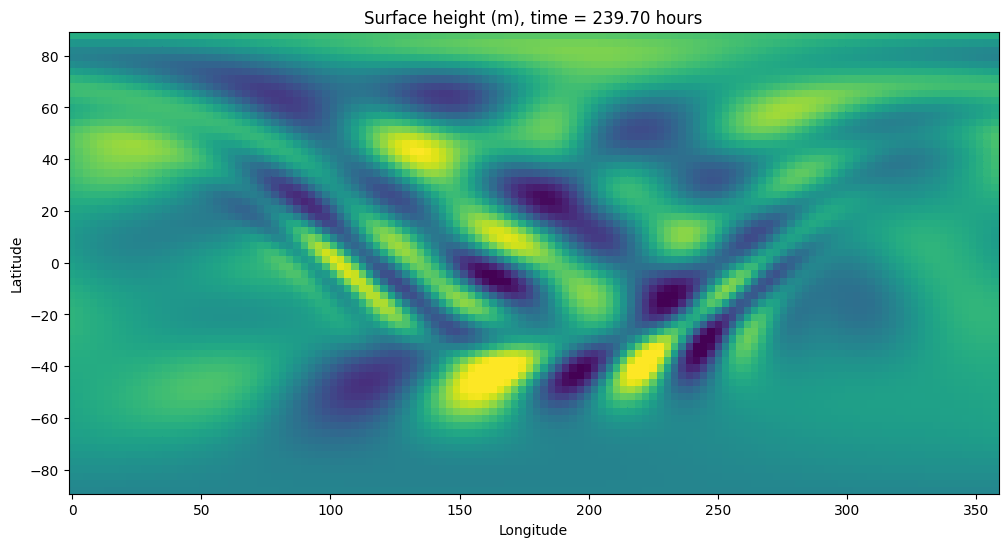

In [97]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. You should modifty the code to save the height more often so that you can clearly see the shape of the wave. Notice that as the waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

32 48


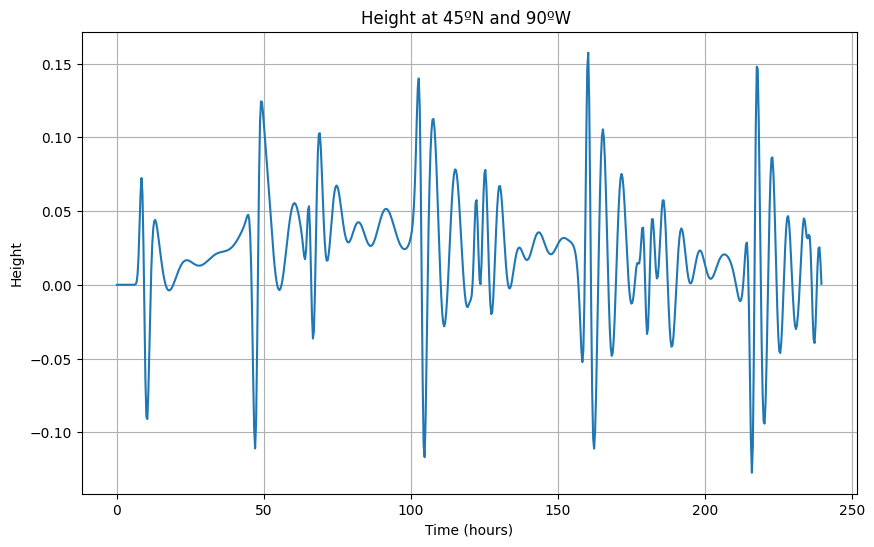

In [113]:
# Reminder to self
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)

print(int(90/360*Nphi), int((90+45)/180*Ntheta))
heights = []
for timeslice in h_save:
  heights.append(timeslice[int(90/360*Nphi)][int((90+45)/180*Ntheta)])

plt.figure(figsize=(10, 6))
plt.plot(np.array(t_save) / hour, heights)

plt.xlabel('Time (hours)')
plt.ylabel('Height')
plt.title(f'Height at 45ºN and 90ºW ')
plt.grid(True)
plt.show()


ADD PLOTS AND DISCUSSION HERE

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves from the theoretical dispersion relation and compare this estimate with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [128]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt
import math

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

# changed for higher resolution
timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity
thetas['g'] = theta

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
# 10 * h * ((1/2 * (1+dedtanh((theta - 3*np.pi/2)/(np.pi/10))) + 1/2 * (1-dedtanh((theta - np.pi/2)/(np.pi/10)))))

dedalustanh = lambda A: np.tanh(A)

problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u) - 1/(0.1 * day) * h * ((1/2 * (1+dedtanh((phi - 3*np.pi/2)/(np.pi/10))) + 1/2 * (1-dedtanh((phi - np.pi/2)/(np.pi/10)))))")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

IndexError: tuple index out of range

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?